In [46]:
import pandas as pd
from google.colab import files
import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import math
from tensorflow import keras
# !pip install -q xlrd


In [2]:
uploaded = files.upload()
# upload 2 files: February 2022 Raw Database.xlsx and 2018-APTA-Infrastructure-Database.xlsx

Saving 2018-APTA-Infrastructure-Database.xlsx to 2018-APTA-Infrastructure-Database.xlsx
Saving February 2022 Raw Database.xlsx to February 2022 Raw Database.xlsx


In [3]:
# Looking at the Connectivity of Mass transit in various locations

# Reading parts of the 2018 APTA Infrastructure database
#file_loc = "C:/Users/mgfly/Documents/MFlynn/Syracuse/Q5/IST 718/Final Project/"
atpa_Idb = "2018-APTA-Infrastructure-Database.xlsx"
#xls = pd.ExcelFile(file_loc + atpa_Idb)

sheet_1 = "Station Data"
sheet_2 = "Rail Lines"
sheet_3 = "BRT lines"

station_df = pd.read_excel(atpa_Idb, sheet_1)
rail_df = pd.read_excel(atpa_Idb, sheet_2)
bus_df = pd.read_excel(atpa_Idb, sheet_3)

In [4]:
#Reading parts of the Feb 2022 Raw DB file
raw_db = "February 2022 Raw Database.xlsx"

rawDB_df = pd.read_excel(raw_db, 'MASTER')
upt_df = pd.read_excel(raw_db, 'UPT')

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [5]:
#Down selecting to columns of interest
station_cols = ["Organization Name", "Organization Short Name",	"City",	"State",	"Country",
                "Member ID",	"Type of Facility",	"Number of Stations", "Number of Bus/Rail Stops"]
station_df_short = station_df[station_cols]
station_df_short

,Organization Name,Organization Short Name,City,State,Country,Member ID,Type of Facility,Number of Stations,Number of Bus/Rail Stops
0,City of Phoenix Public Transit Department,City of Phoenix PTD,Phoenix,AZ,UNITED STATES,6,BUS,15,3994
1,City of Phoenix Public Transit Department,City of Phoenix PTD,Phoenix,AZ,UNITED STATES,6,RAIL,35,0
2,City of Tucson Mass Transit System,City of Tucson MTS,Tucson,AZ,UNITED STATES,7,BUS,23,2291
3,Rock Region METRO,Central Arkansas TA,Little Rock,AR,UNITED STATES,8,BUS,1,1548
4,Rock Region METRO,Central Arkansas TA,Little Rock,AR,UNITED STATES,8,RAIL,0,15
...,...,...,...,...,...,...,...,...,...
496,Bow Valley Regional Transit Services Commission,Roam Transit,Banff,AB,CANADA,98842,BUS,1,80
497,Link Transit (City of Burlington NC),Link Transit,Burlington,NC,UNITED STATES,105173,BUS,1,150
498,University of California San Francisco,NaN,San Francisco,CA,UNITED STATES,119308,BUS,0,0
499,Strathcona County Transit,Strathcona County Transit,Sherwood Park,AB,CANADA,131921,BUS,2,320


Text(0, 0.5, 'Number or Stops')

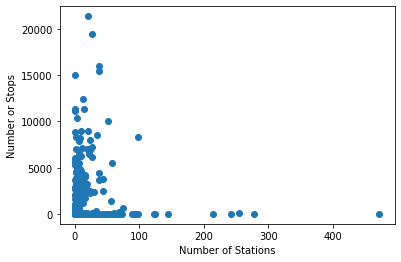

In [6]:
# crude plot to see if stations and stops are related
plt.scatter(station_df_short["Number of Stations"], station_df_short["Number of Bus/Rail Stops"])
plt.xlabel("Number of Stations")
plt.ylabel("Number or Stops")

In [7]:
#Down selecting to columns of interest
rawDB_cols = ["Agency", "Mode", "HQ City", "HQ State", "UZA", "UZA Name", 
              "UZA Area SQ Miles", "UZA Population", "Service Area SQ Miles", 
              "Service Area Population", "Passenger Miles FY", "Unlinked Passenger Trips FY", 
              "Average Trip Length FY"]
rawDB_df_short = rawDB_df[rawDB_cols]
rawDB_df_short

,Agency,Mode,HQ City,HQ State,UZA,UZA Name,UZA Area SQ Miles,UZA Population,Service Area SQ Miles,Service Area Population,Passenger Miles FY,Unlinked Passenger Trips FY,Average Trip Length FY
0,King County Department of Metro Transit,DR,SEATTLE,WA,14,"Seattle, WA",1010.0,3059393.0,2134.0,2260800.0,4551838.0,455391.0,9.9955
1,King County Department of Metro Transit,DR,SEATTLE,WA,14,"Seattle, WA",1010.0,3059393.0,2134.0,2260800.0,1003831.0,86460.0,11.6104
2,King County Department of Metro Transit,FB,SEATTLE,WA,14,"Seattle, WA",1010.0,3059393.0,2134.0,2260800.0,896100.0,146930.0,6.0988
3,King County Department of Metro Transit,LR,SEATTLE,WA,14,"Seattle, WA",1010.0,3059393.0,2134.0,2260800.0,NaN,NaN,NaN
4,King County Department of Metro Transit,MB,SEATTLE,WA,14,"Seattle, WA",1010.0,3059393.0,2134.0,2260800.0,210354213.0,48865809.0,4.3047
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,City of Glendale,MB,GLENDALE,CA,2,"Los Angeles-Long Beach-Anaheim, CA",1736.0,12150996.0,39.0,223467.0,2278590.0,1040034.0,2.1909
2246,City of Pasadena,DR,Pasadena,CA,2,"Los Angeles-Long Beach-Anaheim, CA",1736.0,12150996.0,23.0,141371.0,235921.0,68517.0,3.4432
2247,City of Pasadena,MB,Pasadena,CA,2,"Los Angeles-Long Beach-Anaheim, CA",1736.0,12150996.0,23.0,141371.0,2439762.0,1305756.0,1.8685
2248,Pomona Valley Transportation Authority,DR,LA VERNE,CA,2,"Los Angeles-Long Beach-Anaheim, CA",1736.0,12150996.0,61.0,252880.0,279733.0,62210.0,4.4966


In [8]:
#Truncate upt to only include 2018
upt_2018_cols = ['Agency', 'JAN18', 'FEB18', 'MAR18', 'APR18', 'MAY18', 'JUN18',
                 'JUL18', 'AUG18', 'SEP18', 'OCT18', 'NOV18', 'DEC18']
upt_2018_df = upt_df[upt_2018_cols]
upt_2018_nulls = upt_2018_df[upt_2018_df['Agency'].isnull()].index.tolist()

upt_2018_df.drop(upt_2018_nulls, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
#sum ridership by Agency for 2018
upt_2018_df = upt_2018_df.groupby(['Agency']).sum()
upt_2018_df = upt_2018_df.reset_index()
upt_2018_df


,Agency,JAN18,FEB18,MAR18,APR18,MAY18,JUN18,JUL18,AUG18,SEP18,OCT18,NOV18,DEC18
0,"2Plus Partners in Transportation, Inc",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ATC / Vancom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Academy Lines, Inc.",288667.0,268539.0,273879.0,287985.0,288273.0,291875.0,268874.0,281813.0,252656.0,305561.0,254053.0,219688.0
3,Access Services,177613.0,167399.0,186117.0,183038.0,194147.0,183911.0,184059.0,195671.0,182941.0,204174.0,181842.0,170680.0
4,Access Services,174124.0,171475.0,184839.0,184748.0,190247.0,182456.0,186493.0,197022.0,184072.0,194832.0,176451.0,168690.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,"vRide, Inc. - Anchorage",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
805,"vRide, Inc. - Atlanta",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
806,"vRide, Inc. - El Paso",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807,"vRide, Inc. - Tucson",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#find monthly mean ridership by Agency for 2018
upt_2018_df['Avg 2018'] = upt_2018_df.mean(axis = 1)
upt_2018_df = upt_2018_df[['Agency', 'Avg 2018']]                                           
upt_2018_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


,Agency,Avg 2018
0,"2Plus Partners in Transportation, Inc",0.000000
1,ATC / Vancom,0.000000
2,"Academy Lines, Inc.",273488.583333
3,Access Services,184299.333333
4,Access Services,182954.083333
...,...,...
804,"vRide, Inc. - Anchorage",0.000000
805,"vRide, Inc. - Atlanta",0.000000
806,"vRide, Inc. - El Paso",0.000000
807,"vRide, Inc. - Tucson",0.000000


In [11]:
# checking for direct matches between agency and organization
match = 0
for i in sorted(set(rawDB_df_short['Agency'])):
  if i in sorted(set(station_df_short['Organization Name'])):
    #print(i)
    match += 1
print(match, 'direct matches.', len(set(rawDB_df_short['Agency'])), 'Unique Agencies. ',
      len(set(station_df_short['Organization Name'])), 'Unique Organizations.')

#148 found
#***Additional work needed to match organization and agency

148 direct matches. 809 Unique Agencies.  408 Unique Organizations.


In [12]:
#summing trips/miles, storing Area and pop for each agency
agency = list(set(rawDB_df_short['Agency']))
area = []
pop= []
pass_miles = []
pass_trips = []
trip_length = []
type_count = []

for i in agency:
  tmpDF = rawDB_df_short[rawDB_df_short['Agency'] == i]
  area.append(list(tmpDF['Service Area SQ Miles'])[0])
  pop.append(list(tmpDF['Service Area Population'])[0])
  pass_miles.append(sum(pd.to_numeric(tmpDF['Passenger Miles FY']).dropna()))
  pass_trips.append(sum(pd.to_numeric(tmpDF['Unlinked Passenger Trips FY']).dropna()))
  type_count.append(len(set(tmpDF['Mode'])))
  if pass_trips[-1] != 0:
    trip_length.append(pass_miles[-1]/pass_trips[-1])
  else: trip_length.append(0)

rawDB_df_combined = pd.DataFrame({"Agency": agency, "Service Area": area, 
                                  "Service Pop.": pop, "Passenger Miles": pass_miles, 
                                  "Passenger Trips": pass_trips, "Avg. Trip Length": trip_length,
                                  "Transportation Modes": type_count})

# combining Station data by organization
organization = list(set(station_df_short['Organization Name']))
org_short = []
city = []
state = []
country = []
memberID = [] 
stations = [] 
stops = [] 

for i in organization:
  tmpDF = station_df_short[station_df_short['Organization Name'] == i]
  org_short.append(list(tmpDF['Organization Short Name'])[0])
  city.append(list(tmpDF['City'])[0])
  state.append(list(tmpDF['State'])[0])
  country.append(list(tmpDF['Country'])[0])
  memberID.append(list(tmpDF['Member ID'])[0])
  stations.append(sum(pd.to_numeric(tmpDF['Number of Stations']).dropna()))
  stops.append(sum(pd.to_numeric(tmpDF['Number of Bus/Rail Stops']).dropna()))

station_df_combined = pd.DataFrame({"Organization Name": organization, "Organization Short Name": org_short,
                                    "City": city, "State": state, "Country": country,
                                    "Member ID": memberID, "Number of Stations": stations,
                                    "Number of Bus/Rail Stops": stops})

# rough join - removed for imporved matching methods
#station_df_short['Agency'] = station_df_short['Organization Name']
#combined_df = station_df_short.merge(rawDB_df_combined, how = "inner", on="Agency")


' OldPlots\nplt.scatter(combined_df["Number of Bus/Rail Stops"], combined_df["Service Area"])\nplt.xlabel("Number of Stops")\nplt.ylabel("Area (miles^2)")\n\nplt.scatter(combined_df["Number of Stations"], combined_df["Service Area"])\nplt.xlabel("Number of Stations")\nplt.ylabel("Area (miles^2)")\n\nplt.scatter(combined_df["Service Area"], combined_df["Passenger Trips"])\nplt.xlabel("Area (miles^2)")\nplt.ylabel("Passenger Trips")\n#plt.yscale(value = "log")\n\nplt.scatter(combined_df["Service Area"], combined_df["Passenger Miles"])\nplt.xlabel("Area (miles^2)")\nplt.ylabel("Passenger Miles")\n'

In [13]:
# CHECK
#list(rawDB_df_combined['Agency'])
print("Rows:", len(rawDB_df_combined), "\tUnique Agencies:", len(set(rawDB_df_combined['Agency'])))
rawDB_df_combined

Rows: 809 	Unique Agencies: 809


,Agency,Service Area,Service Pop.,Passenger Miles,Passenger Trips,Avg. Trip Length,Transportation Modes
0,Monsey New Square Trails Corporation,176.0,286573.0,15217978.0,364616.0,41.737000,2
1,Stark Area Regional Transit Authority,581.0,375586.0,9222375.0,1334801.0,6.909176,2
2,San Mateo County Transit District,97.0,773244.0,39269344.0,9227255.0,4.255799,2
3,"City of Huntsville, Alabama",56.0,114598.0,2831273.0,639489.0,4.427399,2
4,City of Sharon,173.0,96432.0,0.0,0.0,0.000000,2
...,...,...,...,...,...,...,...
804,City of Springfield,95.0,195061.0,4476103.0,914583.0,4.894146,2
805,Chemung County,408.0,95195.0,0.0,0.0,0.000000,2
806,Lehigh and Northampton Transportation Authority,324.0,533100.0,22377366.0,4036833.0,5.543297,2
807,University of Michigan Parking and Transportat...,12.0,66641.0,11723072.0,5718494.0,2.050028,1


In [1]:
#Adding 2018 average monthly ridership
rawDB_df_combined = rawDB_df_combined.merge(upt_2018_df, how = "inner", on="Agency")
rawDB_df_combined

NameError: ignored

In [15]:
#CHECK
#rawDB_df_short[rawDB_df_short['Agency']== 'Metropolitan Suburban Bus Authority, dba: MTA Long Island Bus']
print("Rows:", len(station_df_combined), "\tUnique Orgs.:", len(set(station_df_combined['Organization Name'])))
station_df_combined

Rows: 408 	Unique Orgs.: 408


,Organization Name,Organization Short Name,City,State,Country,Member ID,Number of Stations,Number of Bus/Rail Stops
0,Stark Area Regional Transit Authority,Stark Area RTA,Canton,OH,UNITED STATES,190,4,1504
1,City of Kalamazoo Public Transportation Division,City of Kalamazoo PTD,Kalamazoo,MI,UNITED STATES,131,1,739
2,Citibus,Citibus,Lubbock,TX,UNITED STATES,235,1,800
3,San Mateo County Transit District,San Mateo County TD,San Carlos,CA,UNITED STATES,30,16,2155
4,Chittenden County Transportation Authority,Chittenden County TA,Burlington,VT,UNITED STATES,248,2,677
...,...,...,...,...,...,...,...,...
403,CityBus of Greater Lafayette,CityBus of Greater Lafayette,Lafayette,IN,UNITED STATES,90,1,1081
404,Eastern Contra Costa Transit Authority,Eastern Contra Costa TA,Antioch,CA,UNITED STATES,819,0,616
405,Pueblo Transit,Pueblo Transit,Pueblo,CO,UNITED STATES,47,1,546
406,Metropolitan Transit Authority,Metropolitan TA,Nashville,TN,UNITED STATES,230,2,3145


In [16]:
# matching agencies and organizations
station_org = list(station_df_combined["Organization Name"])
rawDB_agency = list(rawDB_df_combined["Agency"])

matched = {} #{Organzation: Agency}

# start with string length 4 and attempt a match
# if more than one are found, increase string length by 1 and try again
# if string length > organization name length - end
for i in station_org:
  start = 0
  end = 4
  matches = [agency for agency in rawDB_agency if i[start:end] in agency]
  while (len(matches) > 1) and (end < len(i)):
    end +=1
    matches = [agency for agency in matches if i[start:end] in agency]
  matched[i] = [len(matches), matches]

In [17]:
#add "Organization Name" to station_df_combined to be used in merge
station_df_combined['Agency'] = station_df_combined['Organization Name']
#combined_df = station_df_short.merge(rawDB_df_combined, how = "inner", on="Agency")
total = 0

# check number of matches now
for i in matched:
  if matched[i][0] == 1:
    total += 1
    org_index = station_df_combined[station_df_combined['Organization Name']== i].index[0]
    #print(i, ':',org_index)
    agency_index = rawDB_df_combined[rawDB_df_combined['Agency'] == matched[i][1][0]].index[0]
    #print(matched[i][1][0],':', agency_index, "\n")
    station_df_combined.loc[org_index,['Agency']] = rawDB_df_combined.iloc[agency_index]['Agency']

print("total", total)
#combined_df = station_df_combined.merge(rawDB_df_combined, how = "inner", on="Agency")

total 302


In [18]:
#merge data frames
combined_df = station_df_combined.merge(rawDB_df_combined, how = "inner", on="Agency")

In [19]:
#Check merged df length, unique Agencies and unique Orgs
# clean up in all are not equal
print(len(combined_df), len(set(list(combined_df['Agency']))), len(set(list(combined_df['Organization Name']))))
combined_df

309 292 309


,Organization Name,Organization Short Name,City,State,Country,Member ID,Number of Stations,Number of Bus/Rail Stops,Agency,Service Area,Service Pop.,Passenger Miles,Passenger Trips,Avg. Trip Length,Transportation Modes,Avg 2018
0,Stark Area Regional Transit Authority,Stark Area RTA,Canton,OH,UNITED STATES,190,4,1504,Stark Area Regional Transit Authority,581.0,375586.0,9222375.0,1334801.0,6.909176,2,2.042737e+05
1,San Mateo County Transit District,San Mateo County TD,San Carlos,CA,UNITED STATES,30,16,2155,San Mateo County Transit District,97.0,773244.0,39269344.0,9227255.0,4.255799,2,9.628693e+05
2,Transit Authority of River City,TA of River City,Louisville,KY,UNITED STATES,103,1,5500,Transit Authority of River City,357.0,806893.0,39128540.0,8711427.0,4.491634,2,1.014226e+06
3,Simi Valley Transit,Simi Valley Transit,Simi Valley,CA,UNITED STATES,36,0,238,City of Simi Valley,42.0,126878.0,0.0,0.0,0.000000,2,0.000000e+00
4,County of Lackawanna Transit System,NaN,Scranton,PA,UNITED STATES,213,0,340,County of Lackawanna Transit System,170.0,214437.0,4710006.0,923727.0,5.098916,2,9.635075e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,City of Modesto Modesto Area Express - MAX,MAX,Modesto,CA,UNITED STATES,2723,1,750,City of Modesto,59.0,271314.0,8735832.0,2057603.0,4.245635,2,2.061250e+05
305,Eastern Contra Costa Transit Authority,Eastern Contra Costa TA,Antioch,CA,UNITED STATES,819,0,616,The Eastern Contra Costa Transit Authority,225.0,328500.0,7503076.0,1535179.0,4.887427,2,1.836606e+05
306,Pueblo Transit,Pueblo Transit,Pueblo,CO,UNITED STATES,47,1,546,City of Pueblo,39.0,112933.0,1965716.0,496659.0,3.957879,2,7.202417e+04
307,Metropolitan Transit Authority,Metropolitan TA,Nashville,TN,UNITED STATES,230,2,3145,Metropolitan Transit Authority,504.0,694144.0,36759655.0,7719131.0,4.762149,3,8.163733e+05


In [20]:
#check for dulicates
for i in set(list(combined_df['Agency'])):
  tmpDF = combined_df[combined_df['Agency']==i]
  if len(tmpDF) > 1:
    if len(tmpDF) == 2:
      print(tmpDF.index[0],':', list(tmpDF['Organization Name'])[0],';', list(tmpDF['Agency'])[0])
      print(tmpDF.index[1],':', list(tmpDF['Organization Name'])[1],';', list(tmpDF['Agency'])[1], "\n")
    if len(tmpDF) == 3:
      print(tmpDF.index[0],':', list(tmpDF['Organization Name'])[0],';', list(tmpDF['Agency'])[0])
      print(tmpDF.index[1],':', list(tmpDF['Organization Name'])[1],';', list(tmpDF['Agency'])[1])
      print(tmpDF.index[2],':', list(tmpDF['Organization Name'])[2],';', list(tmpDF['Agency'])[2], "\n")

21 : Dallas Area Rapid Transit Authority ; Dallas Area Rapid Transit
22 : Dallas Streetcar ; Dallas Area Rapid Transit 

76 : Pierce Transit ; Pierce County Transportation Benefit Area Authority
77 : Pierce County Ferry Operations ; Pierce County Transportation Benefit Area Authority 

99 : Casco Bay Island Transit District ; Casco Bay Island Transit District
100 : Island Transit ; Casco Bay Island Transit District 

102 : San Joaquin Regional Transit District ; San Joaquin Regional Transit District
103 : San Joaquin Regional Rail Commission ; San Joaquin Regional Transit District 

123 : Southern Nevada Transit Coalition ; Regional Transportation Commission of Southern Nevada
124 : Regional Transportation Commission of Southern Nevada ; Regional Transportation Commission of Southern Nevada 

258 : Southwest Ohio Regional Transit Authority ; Southwest Ohio Regional Transit Authority
259 : Southwest Metro Transit ; Southwest Ohio Regional Transit Authority 

203 : Central New York Regio

In [35]:
#add incorrect matche index to a list
idx_to_drop = []
idx_to_drop.append(combined_df[combined_df['Organization Name'] == 'Dallas Streetcar'].index[0])
idx_to_drop.append(combined_df[combined_df['Organization Name'] == 'Pierce County Ferry Operations'].index[0])
idx_to_drop.append(combined_df[combined_df['Organization Name'] == 'Island Transit'].index[0])
idx_to_drop.append(combined_df[combined_df['Organization Name'] == 'San Joaquin Regional Rail Commission'].index[0])
idx_to_drop.append(combined_df[combined_df['Organization Name'] == 'Southern Nevada Transit Coalition'].index[0])
idx_to_drop.append(combined_df[combined_df['Organization Name'] == 'Southwest Metro Transit'].index[0])
idx_to_drop.append(combined_df[combined_df['Organization Name'] == 'York Region Transit'].index[0])
idx_to_drop.append(combined_df[combined_df['Organization Name'] == 'Port Authority of New York and New Jersey'].index[0])
idx_to_drop.append(combined_df[combined_df['Organization Name'] == 'Butler Township/City Joint Municipal Transit Authority'].index[0])
idx_to_drop.append(combined_df[combined_df['Organization Name'] == 'Mountain Metropolitan Transit'].index[0])
idx_to_drop.append(combined_df[combined_df['Organization Name'] == 'Mountain Line Transit Authority'].index[0])
idx_to_drop.append(combined_df[combined_df['Organization Name'] == 'Mountain Area Regional Transit Authority'].index[0])
idx_to_drop.append(combined_df[combined_df['Organization Name'] == 'Franklin Transit Authority'].index[0])
idx_to_drop.append(combined_df[combined_df['Organization Name'] == 'Madison Metro'].index[0])
idx_to_drop.append(combined_df[combined_df['Organization Name'] == 'Alameda-Oakland Ferry Service'].index[0])
idx_to_drop.append(combined_df[combined_df['Organization Name'] == 'City of Tucson Mass Transit System'].index[0])
idx_to_drop.append(combined_df[combined_df['Organization Name'] == 'Transit Management of Spartanburg'].index[0])
idx_to_drop.append(combined_df[combined_df['Organization Name'] == 'Temporary Login'].index[0])
idx_to_drop

[22, 77, 100, 103, 123, 259, 204, 47, 49, 17, 18, 19, 26, 218, 88, 183, 28, 54]

In [36]:
#idx_to_drop = [37, 90, 153, 6, 176, 230, 110, 138, 41, 33, 18, 72, 46, 25, 26, 27, 67, 208]
#idx_to_drop = [81, 92, 70, 180, 147, 148, 149, 99, 131, 260, 195, 35, 89, 101, 219, 153, 62, 108]
#idx_to_drop = [23,15,16,17,18,77,0,100,236,34,151,72,211,143,37,67,178,51]

#Drop incorrect matches
combined_df.drop(idx_to_drop, inplace = True)

#re-check matched DF
print(len(combined_df), len(set(list(combined_df['Agency']))), len(set(list(combined_df['Organization Name']))), len(set(combined_df['Member ID'])))
combined_df

291 291 291 291


,Organization Name,Organization Short Name,City,State,Country,Member ID,Number of Stations,Number of Bus/Rail Stops,Agency,Service Area,Service Pop.,Passenger Miles,Passenger Trips,Avg. Trip Length,Transportation Modes,Avg 2018
0,Stark Area Regional Transit Authority,Stark Area RTA,Canton,OH,UNITED STATES,190,4,1504,Stark Area Regional Transit Authority,581.0,375586.0,9222375.0,1334801.0,6.909176,2,2.042737e+05
1,San Mateo County Transit District,San Mateo County TD,San Carlos,CA,UNITED STATES,30,16,2155,San Mateo County Transit District,97.0,773244.0,39269344.0,9227255.0,4.255799,2,9.628693e+05
2,Transit Authority of River City,TA of River City,Louisville,KY,UNITED STATES,103,1,5500,Transit Authority of River City,357.0,806893.0,39128540.0,8711427.0,4.491634,2,1.014226e+06
3,Simi Valley Transit,Simi Valley Transit,Simi Valley,CA,UNITED STATES,36,0,238,City of Simi Valley,42.0,126878.0,0.0,0.0,0.000000,2,0.000000e+00
4,County of Lackawanna Transit System,NaN,Scranton,PA,UNITED STATES,213,0,340,County of Lackawanna Transit System,170.0,214437.0,4710006.0,923727.0,5.098916,2,9.635075e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,City of Modesto Modesto Area Express - MAX,MAX,Modesto,CA,UNITED STATES,2723,1,750,City of Modesto,59.0,271314.0,8735832.0,2057603.0,4.245635,2,2.061250e+05
305,Eastern Contra Costa Transit Authority,Eastern Contra Costa TA,Antioch,CA,UNITED STATES,819,0,616,The Eastern Contra Costa Transit Authority,225.0,328500.0,7503076.0,1535179.0,4.887427,2,1.836606e+05
306,Pueblo Transit,Pueblo Transit,Pueblo,CO,UNITED STATES,47,1,546,City of Pueblo,39.0,112933.0,1965716.0,496659.0,3.957879,2,7.202417e+04
307,Metropolitan Transit Authority,Metropolitan TA,Nashville,TN,UNITED STATES,230,2,3145,Metropolitan Transit Authority,504.0,694144.0,36759655.0,7719131.0,4.762149,3,8.163733e+05


In [37]:
rail_df

,New 2018 Data,Last Data Reported Year,Organization Name,Organization Short Name,City,State,Country,Member ID,Mode Name,Connecting Modes,...,Miles of mainline passenger track,Miles of yard and non-mainline track,Crossings with Gates,Crossings without Gates,Longest platform (feet),Maximum speed (m.p.h.),Average Speed (MPH),Shortest headway (min. & sec.),Start of Operations (hours & minutes military time),End of Operations (hours & minutes military time)
0,No,2016.0,City of Phoenix Public Transit Department,City of Phoenix PTD,Phoenix,AZ,UNITED STATES,6,LIGHT RAIL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Yes,2018.0,Rock Region METRO,Central Arkansas TA,Little Rock,AR,UNITED STATES,8,STREETCAR RAILWAY,L,...,3.5,0.3,0.0,0.0,50.0,14.0,NaN,NaN,NaN,NaN
2,No,NaN,Montebello Bus Lines,Montebello Bus Lines,Montebello,CA,UNITED STATES,19,COMMUTER RAIL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,No,2013.0,North San Diego County Transit District,North SD County TD,Oceanside,CA,UNITED STATES,21,COMMUTER RAIL,"B, IB, L,,IR",...,69.1,23.9,34.0,0.0,1000.0,90.0,NaN,25:00,NaN,NaN
4,No,2013.0,North San Diego County Transit District,North SD County TD,Oceanside,CA,UNITED STATES,21,LIGHT RAIL,"B, IB, C,IR",...,32.5,1.0,41.0,0.0,274.0,55.0,NaN,30:00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,No,2010.0,"Valley Metro Rail, Inc.","Valley Metro Rail, Inc.",Phoenix,AZ,UNITED STATES,3522,LIGHT RAIL,Bus,...,40.0,4.0,5.0,148.0,300.0,40.0,NaN,12:00,NaN,NaN
106,No,2015.0,Detroit Transportation Corporation,Detroit Transportation Corporation,Detroit,MI,UNITED STATES,3534,LIGHT RAIL,0,...,2.9,0.5,0.0,0.0,120.0,35.0,NaN,1:30,NaN,NaN
107,No,2015.0,Detroit Transportation Corporation,Detroit Transportation Corporation,Detroit,MI,UNITED STATES,3534,AUTOMATED GUIDEWAY,0,...,2.9,0.5,0.0,0.0,120.0,35.0,NaN,1:30,NaN,NaN
108,No,NaN,Portland Streetcar,Portland Streetcar,Portland,OR,UNITED STATES,14591,LIGHT RAIL,"B,L",...,5.9,0.2,0.0,87.0,60.0,15.0,NaN,13:00,NaN,NaN


In [38]:
# combining Station data by organization
organization_rail = list(set(rail_df['Organization Name']))
memberID = [] 
miles = [] 
max_speed = []

for i in organization_rail:
  tmpDF = rail_df[rail_df['Organization Name'] == i]
  memberID.append(list(tmpDF['Member ID'])[0])
  rail_miles = sum(pd.to_numeric(tmpDF['Miles of mainline passenger track']).dropna())
  if i in list(set(bus_df['Organization Name'])):
    tmpDF2 = bus_df[bus_df['Organization Name'] == i]
    bus_miles = sum(pd.to_numeric(tmpDF2['Route Length (Miles)']).dropna())
    miles.append(bus_miles+rail_miles)
  else: 
    miles.append(rail_miles)
  if sum(pd.notnull(tmpDF['Maximum speed (m.p.h.)'])>=1):
    max_speed.append(max(list(pd.to_numeric(tmpDF['Maximum speed (m.p.h.)'].dropna()))))
  else: max_speed.append(None)

#rail_bus_df_combined = pd.DataFrame({"Organization Name": organization_rail, "Member ID": memberID,
#                                     "Miles": miles, "Max. Speed": max_speed})

rail_bus_df_combined = pd.DataFrame({"Member ID": memberID,
                                     "Miles": miles, "Max. Speed": max_speed})


In [39]:
#tmpDF = rail_df[rail_df['Organization Name'] == 'Maryland Transit Administration']
#max(list(pd.to_numeric(tmpDF['Maximum speed (m.p.h.)'])))
              

In [40]:
#merge DF to include miles and max speed
combined_df_with_miles = combined_df.merge(rail_bus_df_combined, how = "left", on="Member ID")

In [41]:
combined_df_with_miles

,Organization Name,Organization Short Name,City,State,Country,Member ID,Number of Stations,Number of Bus/Rail Stops,Agency,Service Area,Service Pop.,Passenger Miles,Passenger Trips,Avg. Trip Length,Transportation Modes,Avg 2018,Miles,Max. Speed
0,Stark Area Regional Transit Authority,Stark Area RTA,Canton,OH,UNITED STATES,190,4,1504,Stark Area Regional Transit Authority,581.0,375586.0,9222375.0,1334801.0,6.909176,2,2.042737e+05,NaN,NaN
1,San Mateo County Transit District,San Mateo County TD,San Carlos,CA,UNITED STATES,30,16,2155,San Mateo County Transit District,97.0,773244.0,39269344.0,9227255.0,4.255799,2,9.628693e+05,NaN,NaN
2,Transit Authority of River City,TA of River City,Louisville,KY,UNITED STATES,103,1,5500,Transit Authority of River City,357.0,806893.0,39128540.0,8711427.0,4.491634,2,1.014226e+06,NaN,NaN
3,Simi Valley Transit,Simi Valley Transit,Simi Valley,CA,UNITED STATES,36,0,238,City of Simi Valley,42.0,126878.0,0.0,0.0,0.000000,2,0.000000e+00,NaN,NaN
4,County of Lackawanna Transit System,NaN,Scranton,PA,UNITED STATES,213,0,340,County of Lackawanna Transit System,170.0,214437.0,4710006.0,923727.0,5.098916,2,9.635075e+04,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,City of Modesto Modesto Area Express - MAX,MAX,Modesto,CA,UNITED STATES,2723,1,750,City of Modesto,59.0,271314.0,8735832.0,2057603.0,4.245635,2,2.061250e+05,NaN,NaN
287,Eastern Contra Costa Transit Authority,Eastern Contra Costa TA,Antioch,CA,UNITED STATES,819,0,616,The Eastern Contra Costa Transit Authority,225.0,328500.0,7503076.0,1535179.0,4.887427,2,1.836606e+05,NaN,NaN
288,Pueblo Transit,Pueblo Transit,Pueblo,CO,UNITED STATES,47,1,546,City of Pueblo,39.0,112933.0,1965716.0,496659.0,3.957879,2,7.202417e+04,NaN,NaN
289,Metropolitan Transit Authority,Metropolitan TA,Nashville,TN,UNITED STATES,230,2,3145,Metropolitan Transit Authority,504.0,694144.0,36759655.0,7719131.0,4.762149,3,8.163733e+05,NaN,NaN


Text(0, 0.5, 'Route Miles')

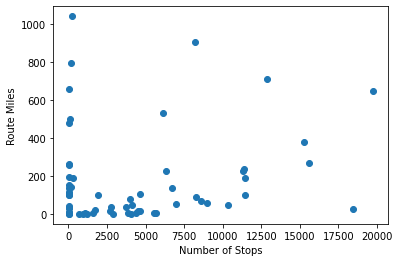

In [42]:
#crude plot check relationship between route length and stops
#Can we estimate missing values? - NO
plt.scatter((combined_df_with_miles["Number of Bus/Rail Stops"]+combined_df_with_miles["Number of Stations"]), combined_df_with_miles["Miles"])
plt.xlabel("Number of Stops")
plt.ylabel("Route Miles")


Text(0.5, 1.0, 'Monthly Rides vs. Transit Route Miles')

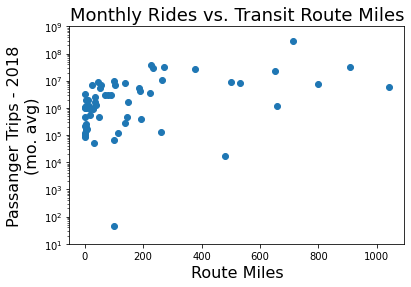

In [55]:
#check relationship between route length and ridership
plt.scatter(combined_df_with_miles["Miles"], combined_df_with_miles["Avg 2018"])
plt.xlabel("Route Miles", size = 16)
plt.ylabel("Passanger Trips - 2018\n(mo. avg)", size = 16)
plt.yscale(value = "log")
plt.ylim([10,1000000000])
plt.title("Monthly Rides vs. Transit Route Miles", size = 18)


,Organization Name,Organization Short Name,City,State,Country,Member ID,Number of Stations,Number of Bus/Rail Stops,Agency,Service Area,Service Pop.,Passenger Miles,Passenger Trips,Avg. Trip Length,Transportation Modes,Avg 2018,Miles,Max. Speed
52,City of El Paso Mass Transit Department,City of El Paso MTD,El Paso,TX,UNITED STATES,243,8,2873,City of El Paso,250.0,747495.0,41680941.0,6070634.0,6.865995,3,1.046696e+06,0.0,NaN
70,Montebello Bus Lines,Montebello Bus Lines,Montebello,CA,UNITED STATES,19,1,950,City of Montebello,151.0,315074.0,15213456.0,3920619.0,3.880371,3,4.645628e+05,0.0,NaN
82,Sonoma Marin Area Rail Transit District,Sonoma Marin Area Rail Transit District,Novato,CA,UNITED STATES,3044,10,0,County of Sonoma,398.0,500675.0,6595710.0,769935.0,8.566580,2,8.190700e+04,0.0,NaN
109,Chattanooga Area Regional Transportation Autho...,Chattanooga Area RTA,Chattanooga,TN,UNITED STATES,227,5,63,Chattanooga Area Regional Transportation Autho...,289.0,167674.0,6674093.0,2096313.0,3.183729,3,2.233456e+05,1.0,8.0
135,City of Detroit Department of Transportation,City of Detroit DOT,Detroit,MI,UNITED STATES,126,2,5700,City of Detroit,144.0,713777.0,90266853.0,18705653.0,4.825646,3,1.970123e+06,2.9,29.0
141,City of Phoenix Public Transit Department,City of Phoenix PTD,Phoenix,AZ,UNITED STATES,6,50,3994,City of Phoenix Public Transit Department,520.0,2034618.0,109722464.0,30630461.0,3.582136,2,3.327841e+06,0.0,NaN
194,Hillsborough Area Regional Transit Authority,Hillsborough Area RTA,Tampa,FL,UNITED STATES,783,20,3862,Hillsborough Area Regional Transit Authority,255.0,807015.0,52077742.0,9026968.0,5.769129,5,1.030848e+06,2.7,30.0
208,Central Oklahoma Transportation and Parking Au...,Central Oklahoma TPA,Oklahoma City,OK,UNITED STATES,202,6,1100,Central Oklahoma Transportation and Parking Au...,283.0,783134.0,13497410.0,3021932.0,4.466484,5,2.483273e+05,4.8,25.0
216,Kenosha Transit,Kenosha Transit,Kenosha,WI,UNITED STATES,1858,4,700,City of Kenosha,27.0,99894.0,2593759.0,801277.0,3.237032,4,1.173138e+05,1.9,NaN
240,Cambria County Transit Authority,Cambria County TA,Johnstown,PA,UNITED STATES,207,3,1202,Cambria County Transit Authority,688.0,130192.0,4030734.0,1085950.0,3.711712,3,9.830667e+04,0.4,4.0


(10000, 1000000000)

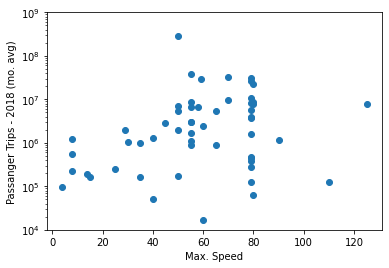

In [44]:
#check relationship between max speed and ridership
plt.scatter(combined_df_with_miles["Max. Speed"], combined_df_with_miles["Avg 2018"])
plt.xlabel("Max. Speed")
plt.ylabel("Passanger Trips - 2018 (mo. avg)")
plt.yscale(value = "log")
plt.ylim([10000,1000000000])

Text(0.5, 1.0, 'Monthly Rides vs. Stops & Stations')

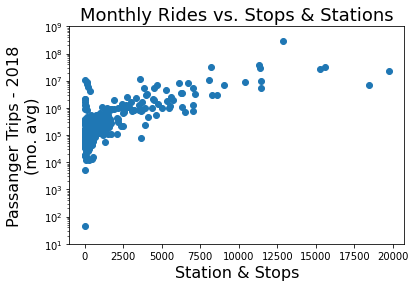

In [65]:
#check relationship between stations + stops and ridership
plt.scatter((combined_df_with_miles["Number of Bus/Rail Stops"]+combined_df_with_miles["Number of Stations"]), combined_df_with_miles["Avg 2018"])
plt.xlabel("Station & Stops", size = 16)
plt.ylabel("Passanger Trips - 2018\n(mo. avg)", size = 16)
plt.yscale(value = "log")
plt.ylim([10,1000000000])
plt.title("Monthly Rides vs. Stops & Stations", size = 18)

Text(0.5, 1.0, 'Monthly Rides vs. Stations')

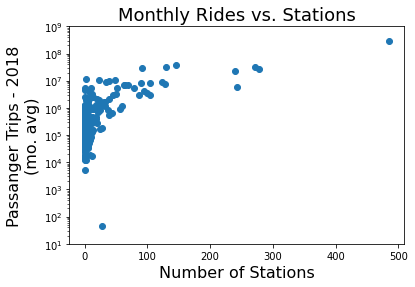

In [64]:
#check relationship between stations and ridership
plt.scatter(combined_df_with_miles["Number of Stations"], combined_df_with_miles["Avg 2018"])
plt.xlabel("Number of Stations", size = 16)
plt.ylabel("Passanger Trips - 2018\n(mo. avg)", size = 16)
plt.yscale(value = "log")
plt.ylim([10,1000000000])
plt.title("Monthly Rides vs. Stations", size = 18)

Text(0.5, 1.0, 'Monthly Rides vs. Stops')

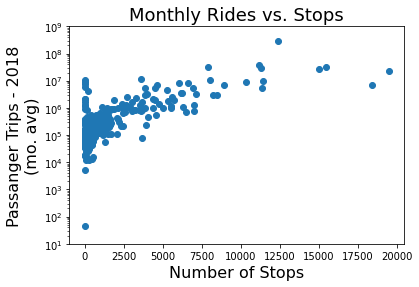

In [63]:
#check relationship between stops and ridership
plt.scatter(combined_df_with_miles["Number of Bus/Rail Stops"], combined_df_with_miles["Avg 2018"])
plt.xlabel("Number of Stops", size = 16)
plt.ylabel("Passanger Trips - 2018\n(mo. avg)", size = 16)
plt.yscale(value = "log")
plt.ylim([10,1000000000])
plt.title("Monthly Rides vs. Stops", size = 18)

In [47]:
#Linear Regression for Ridership

LR_df = combined_df[['Number of Stations', 'Number of Bus/Rail Stops',	'Service Area',	'Service Pop.', 'Avg 2018', 'Transportation Modes']]
LR_df = LR_df[LR_df['Avg 2018']> 0]

trips = np.array(LR_df['Avg 2018'])
LR_df = LR_df.drop('Avg 2018', axis = 1)

feature_list = list(LR_df.columns)

features = np.array(LR_df)

In [48]:
train_features, test_features, train_trips, test_trips = train_test_split(features, trips, test_size = 0.2, random_state = 11)

print('Training Features Shape:', train_features.shape)
print('Training Trips Shape:', train_trips.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Trips Shape:', test_trips.shape)

Training Features Shape: (203, 5)
Training Trips Shape: (203,)
Testing Features Shape: (51, 5)
Testing Trips Shape: (51,)


In [49]:
LR = linear_model.LinearRegression()
LR.fit(train_features, train_trips)

LR_predictions = LR.predict(test_features)

Root Mean Squared Error: 7869014.2 trips


Text(0.5, 1.0, 'Multiple Linear Regression')

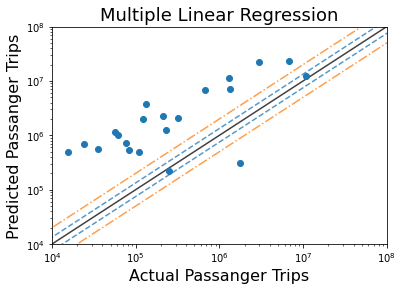

In [66]:
errors = abs(LR_predictions - test_trips)

print('Root Mean Squared Error:', round(math.sqrt(np.mean(errors ** 2)), 2), 'trips')

plt.scatter(test_trips, LR_predictions)
plt.xlabel("Actual Passanger Trips", size = 16)
plt.ylabel("Predicted Passanger Trips", size = 16)
plt.yscale(value = "log")
plt.ylim([10000,100000000])
plt.xscale(value = "log")
plt.xlim([10000,100000000])
plt.plot([10000,1000000000], [10000,1000000000], 'k-', alpha=0.75, zorder=0)
plt.plot([10000,1000000000], [7500,750000000], '--', alpha=0.75, zorder=0)
plt.plot([10000,1000000000], [5000,500000000], '-.', alpha=0.75, zorder=0)
plt.plot([7500,750000000], [10000,1000000000], '--', color = '#1f77b4', alpha=0.75, zorder=0)
plt.plot([5000,500000000], [10000,1000000000], '-.', color = '#ff7f0e', alpha=0.75, zorder=0)
plt.title('Multiple Linear Regression', size = 18)

In [67]:
# Create DF for models 

RF_df = combined_df[['Number of Stations', 'Number of Bus/Rail Stops',	'Service Area',	'Service Pop.', 'Avg 2018', 'Transportation Modes']]
RF_df = RF_df[RF_df['Avg 2018']> 0]
RF_df.describe()

,Number of Stations,Number of Bus/Rail Stops,Service Area,Service Pop.,Avg 2018,Transportation Modes
count,254.000000,254.000000,254.000000,2.540000e+02,2.540000e+02,254.000000
mean,18.303150,2042.850394,527.511811,1.024310e+06,2.834891e+06,2.803150
std,49.139298,3125.473035,927.708779,1.746993e+06,1.818403e+07,1.291746
min,0.000000,0.000000,3.000000,1.976600e+04,4.333333e+01,1.000000
25%,1.000000,151.500000,71.250000,1.683232e+05,1.096864e+05,2.000000
50%,3.000000,831.500000,242.500000,4.113830e+05,2.727973e+05,3.000000
75%,11.000000,2513.500000,525.250000,9.652905e+05,9.776045e+05,3.000000
max,485.000000,19500.000000,9189.000000,1.117034e+07,2.807795e+08,8.000000


[Text(0.5, 1.0, 'Avg 2018 Ridership Correlations')]

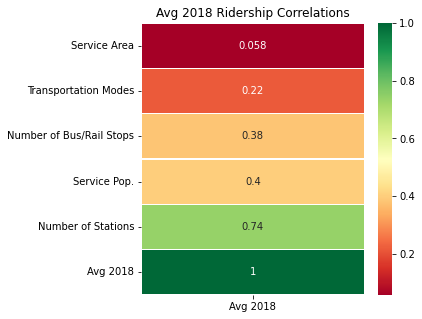

In [68]:
#Check Correlations
RF_df_corr = RF_df.copy()
#combined_df_corr['State'] = combined_df_corr['State'].astype("category")

corrDF_RF = RF_df_corr.corr()
corrDF_RF_avg2018 = corrDF_RF.iloc[:,-2:-1]

ridershipCorr_RF = corrDF_RF_avg2018.sort_values('Avg 2018')
fig, ax = plt.subplots(figsize = (5, 5))
sns.heatmap(ridershipCorr_RF, cmap ='RdYlGn', linewidths = 0.30, annot = True).set(title='Avg 2018 Ridership Correlations')

In [69]:
#Check Correlations with miles added
RF_df_miles = combined_df_with_miles[['Number of Stations', 'Number of Bus/Rail Stops',	'Service Area',	'Service Pop.', 'Avg 2018', 'Transportation Modes', 'Miles']]
RF_df_miles = RF_df_miles[RF_df_miles['Avg 2018']> 0]
RF_df_miles = RF_df_miles[RF_df_miles['Miles']>0]
RF_df_miles.describe()

,Number of Stations,Number of Bus/Rail Stops,Service Area,Service Pop.,Avg 2018,Transportation Modes,Miles
count,57.000000,57.000000,57.000000,5.700000e+01,5.700000e+01,57.000000,57.000000
mean,65.456140,4433.280702,827.964912,2.493807e+06,1.049799e+07,3.684211,185.107018
std,88.030244,5195.942252,997.596737,2.762158e+06,3.755562e+07,1.928711,250.560713
min,0.000000,0.000000,3.000000,9.247700e+04,4.333333e+01,1.000000,0.400000
25%,13.000000,8.000000,255.000000,7.449010e+05,2.833498e+05,2.000000,17.700000
50%,32.000000,2739.000000,458.000000,1.566004e+06,1.665503e+06,3.000000,90.500000
75%,89.000000,6955.000000,938.000000,3.205700e+06,7.112284e+06,5.000000,228.200000
max,485.000000,19500.000000,5325.000000,1.117034e+07,2.807795e+08,8.000000,1041.900000


[Text(0.5, 1.0, 'Avg 2018 Ridership Correlations')]

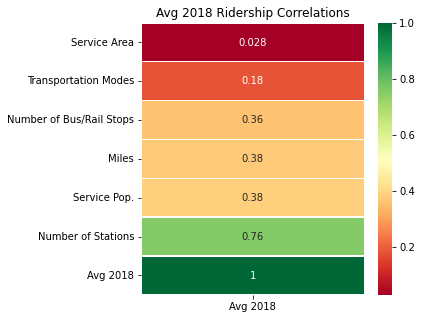

In [70]:
RF_df_miles_corr = RF_df_miles.copy()
#combined_df_corr['State'] = combined_df_corr['State'].astype("category")

corrDF_miles_RF = RF_df_miles_corr.corr()
corrDF_miles_RF_avg2018 = corrDF_miles_RF.iloc[:,-3:-2]

ridershipCorr_miles_RF = corrDF_miles_RF_avg2018.sort_values('Avg 2018')
fig, ax = plt.subplots(figsize = (5, 5))
sns.heatmap(ridershipCorr_miles_RF, cmap ='RdYlGn', linewidths = 0.30, annot = True).set(title='Avg 2018 Ridership Correlations')

In [71]:
RF_df_speed = combined_df_with_miles[['Number of Stations', 'Number of Bus/Rail Stops',	'Service Area',	'Service Pop.', 'Avg 2018', 'Transportation Modes', 'Miles', 'Max. Speed']]
RF_df_speed = RF_df_speed[RF_df_speed['Avg 2018']> 0]
RF_df_speed = RF_df_speed[RF_df_speed['Miles']>0]
RF_df_speed = RF_df_speed[RF_df_speed['Max. Speed']>0]
RF_df_speed.describe()

,Number of Stations,Number of Bus/Rail Stops,Service Area,Service Pop.,Avg 2018,Transportation Modes,Miles,Max. Speed
count,56.000000,56.000000,56.000000,5.600000e+01,5.600000e+01,56.000000,56.000000,56.000000
mean,66.553571,4499.946429,842.267857,2.536555e+06,1.068336e+07,3.678571,188.378571,58.642857
std,88.432598,5218.309414,1000.710266,2.768063e+06,3.786918e+07,1.945691,251.596841,25.541715
min,0.000000,0.000000,3.000000,9.247700e+04,4.333333e+01,1.000000,0.400000,4.000000
25%,13.000000,6.250000,263.250000,7.514665e+05,3.539059e+05,2.000000,18.075000,48.750000
50%,32.000000,3219.500000,492.500000,1.568129e+06,1.817813e+06,3.000000,94.750000,58.500000
75%,89.500000,7198.750000,941.000000,3.206184e+06,7.259994e+06,5.000000,230.050000,79.000000
max,485.000000,19500.000000,5325.000000,1.117034e+07,2.807795e+08,8.000000,1041.900000,125.000000


[Text(0.5, 1.0, 'Avg 2018 Ridership Correlations')]

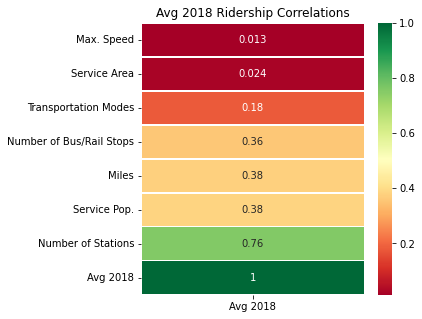

In [72]:
RF_df_speed_corr = RF_df_speed.copy()
#combined_df_corr['State'] = combined_df_corr['State'].astype("category")

corrDF_speed_RF = RF_df_speed_corr.corr()
corrDF_speed_RF_avg2018 = corrDF_speed_RF.iloc[:,-4:-3]

ridershipCorr_speed_RF = corrDF_speed_RF_avg2018.sort_values('Avg 2018')
fig, ax = plt.subplots(figsize = (5, 5))
sns.heatmap(ridershipCorr_speed_RF, cmap ='RdYlGn', linewidths = 0.30, annot = True).set(title='Avg 2018 Ridership Correlations')

In [73]:
#combined_df_with_miles[combined_df_with_miles['Avg 2018'] < 100]

In [74]:
#combined_df_with_miles[combined_df_with_miles['Avg 2018'] > 100000000]


In [75]:
#Duplicating  to use a copy to split test and train

#Random Forest for ridership
#Base model
RF1_df = RF_df.copy()

trips = np.array(RF1_df['Avg 2018'])
RF1_df = RF1_df.drop('Avg 2018', axis = 1)

feature_list = list(RF1_df.columns)

features = np.array(RF1_df)



In [76]:
train_features, test_features, train_trips, test_trips = train_test_split(features, trips, test_size = 0.2, random_state = 11)

print('Training Features Shape:', train_features.shape)
print('Training Trips Shape:', train_trips.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Trips Shape:', test_trips.shape)

Training Features Shape: (203, 5)
Training Trips Shape: (203,)
Testing Features Shape: (51, 5)
Testing Trips Shape: (51,)


In [77]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 11)
rf.fit(train_features, train_trips)

RandomForestRegressor(n_estimators=1000, random_state=11)

Root Mean Squared Error: 2299393.12 trips


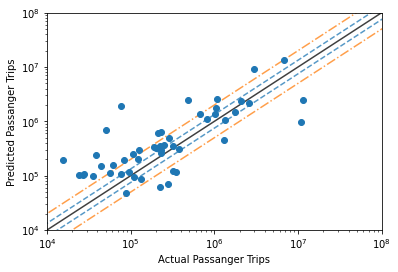

In [78]:
predictions = rf.predict(test_features)
errors = abs(predictions - test_trips)

print('Root Mean Squared Error:', round(math.sqrt(np.mean(errors ** 2)), 2), 'trips')

plt.scatter(test_trips, predictions)
plt.xlabel("Actual Passanger Trips")
plt.ylabel("Predicted Passanger Trips")
plt.yscale(value = "log")
plt.ylim([10000,100000000])
plt.xscale(value = "log")
plt.xlim([10000,100000000])
plt.plot([10000,1000000000], [10000,1000000000], 'k-', alpha=0.75, zorder=0)
plt.plot([10000,1000000000], [7500,750000000], '--', alpha=0.75, zorder=0)
plt.plot([10000,1000000000], [5000,500000000], '-.', alpha=0.75, zorder=0)
plt.plot([7500,750000000], [10000,1000000000], '--', color = '#1f77b4', alpha=0.75, zorder=0)
plt.plot([5000,500000000], [10000,1000000000], '-.', color = '#ff7f0e', alpha=0.75, zorder=0)

In [79]:
#Saving results
RF_ResultsDF = pd.DataFrame({"M1 Actual": test_trips, 'M1 Pred': predictions})

In [80]:
RF_ResultsDF

,M1 Actual,M1 Pred
0,2.401908e+04,1.015124e+05
1,1.079778e+06,2.547431e+06
2,2.329118e+05,2.571240e+05
3,7.568933e+04,1.909549e+06
4,5.050667e+03,2.886450e+05
5,2.276491e+05,2.905702e+05
6,2.233456e+05,6.256646e+04
7,1.283868e+06,4.538975e+05
8,2.768923e+05,7.101138e+04
9,1.072186e+07,9.858824e+05


In [81]:
mape = 100 * (errors / test_trips)
print(mape, np.mean(mape))
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


[ 322.63220842  135.92173492   10.3954701  2422.8777178  5614.98731191
   27.63950232   71.9867042    64.64607656   74.35415577   90.80493086
   11.72439914  281.73281931  132.86826367  292.11392849  248.89302661
   34.93341926   12.02527577 1271.60005602   45.4466333   107.85199786
   14.62135109   54.66087178   20.57897332   18.83992574  189.86528297
  211.51017857  170.08554088  422.5472093   132.23449692  155.27891238
   60.89422222   63.48646474   14.18022506  128.34982739   46.43431265
   65.61178867   70.74073179   17.86575433   78.53459456   67.0369894
   62.42611326   97.49883384   78.18741699 1138.5852208   100.72047508
   33.58127541  524.2197396    14.13721213   34.99968075   37.848003
  179.34673449] 305.4969410078867
Accuracy: -205.5 %.


In [82]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Number of Stations   Importance: 0.75
Variable: Number of Bus/Rail Stops Importance: 0.19
Variable: Service Pop.         Importance: 0.04
Variable: Service Area         Importance: 0.01
Variable: Transportation Modes Importance: 0.01


In [86]:
# Running RF without MTA New York City Transit or New Mexico Department of Transportation
RF2_df = RF_df.copy()

#RF2_df[RF2_df['Avg 2018'] > 100000000]
#RF2_df[RF2_df['Avg 2018'] < 100]

idx_to_drop = []
idx_to_drop.append(RF2_df[RF2_df['Avg 2018'] > 100000000].index[0])
idx_to_drop.append(RF2_df[RF2_df['Avg 2018'] < 100].index[0])
#idx_to_drop
#idx_to_drop = [20, 207]
#idx_to_drop = [257,292]
RF2_df.drop(idx_to_drop, inplace = True)

In [87]:
trips = np.array(RF2_df['Avg 2018'])
RF2_df = RF2_df.drop('Avg 2018', axis = 1)

feature_list = list(RF2_df.columns)

features = np.array(RF2_df)

train_features, test_features, train_trips, test_trips = train_test_split(features, trips, test_size = 0.2, random_state = 11)

print('Training Features Shape:', train_features.shape)
print('Training Trips Shape:', train_trips.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Trips Shape:', test_trips.shape)

Training Features Shape: (201, 5)
Training Trips Shape: (201,)
Testing Features Shape: (51, 5)
Testing Trips Shape: (51,)


In [88]:
rf2 = RandomForestRegressor(n_estimators = 1000, random_state = 11)
rf2.fit(train_features, train_trips)

RandomForestRegressor(n_estimators=1000, random_state=11)

Root Mean Squared Error: 3156804.6030104277


Text(0.5, 1.0, 'Predicted vs. Actual \nMonthly Unlinked Passanger Trips')

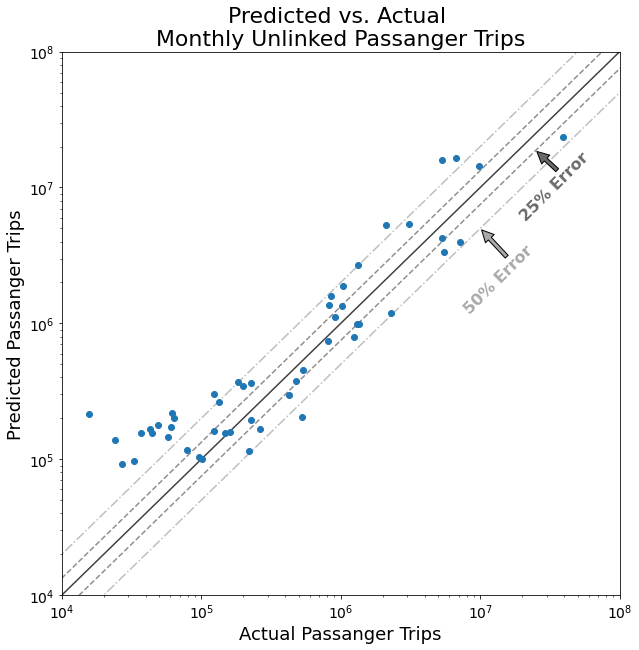

In [89]:
predictions2 = rf2.predict(test_features)
errors = abs(predictions2 - test_trips)

#print('Root Mean Squared Error:', round(math.sqrt(np.mean(errors ** 2)), 2), 'trips')
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_trips, predictions2)))

plt.rcParams["figure.figsize"] = (10,10)

plt.scatter(test_trips, predictions2)
plt.xlabel("Actual Passanger Trips", size = 18)
plt.ylabel("Predicted Passanger Trips", size = 18)
plt.yscale(value = "log")
plt.ylim([10000,100000000])
plt.yticks(fontsize = 14)
plt.xscale(value = "log")
plt.xlim([10000,100000000])
plt.xticks(fontsize = 14)
plt.plot([10000,1000000000], [10000,1000000000], 'k-', alpha=0.75, zorder=0)
plt.plot([10000,1000000000], [7500,750000000], '--', color = '#696969', alpha=0.75, zorder=0)
plt.plot([10000,1000000000], [5000,500000000], '-.', color = '#A9A9A9', alpha=0.75, zorder=0)
plt.plot([7500,750000000], [10000,1000000000], '--', color = '#696969', alpha=0.75, zorder=0)
plt.plot([5000,500000000], [10000,1000000000], '-.', color = '#A9A9A9', alpha=0.75, zorder=0)
plt.annotate("50% Error", xy=(10000000, 5000000), weight = 'bold',
             xytext=(0.85, .65), textcoords='axes fraction',horizontalalignment='right',
             verticalalignment='top', size = 16, color = '#A9A9A9', rotation = 45)
plt.annotate("", xy=(10000000, 5000000), arrowprops=dict(facecolor='#A9A9A9', shrink=0.05),
             xytext=(0.8, .62), textcoords='axes fraction',horizontalalignment='right',
             verticalalignment='top', size = 16, color = '#A9A9A9')
plt.annotate("25% Error", xy=(25000000, 18750000), weight = 'bold',
             xytext=(0.95, .82), textcoords='axes fraction',horizontalalignment='right',
             verticalalignment='top', size = 16, color = '#696969', rotation = 45)
plt.annotate("", xy=(25000000, 18750000), arrowprops=dict(facecolor='#696969', shrink=0.05),
             xytext=(0.89, .78), textcoords='axes fraction',horizontalalignment='right',
             verticalalignment='top', size = 16, color = '#696969')
plt.title("Predicted vs. Actual \nMonthly Unlinked Passanger Trips", size = 22)

In [90]:
#Saving results
RF_ResultsDF['M2 Actual'] = test_trips
RF_ResultsDF['M2 Pred'] = predictions2

In [91]:
# Get numerical feature importances
importances = list(rf2.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Number of Bus/Rail Stops Importance: 0.54
Variable: Number of Stations   Importance: 0.3
Variable: Service Pop.         Importance: 0.11
Variable: Service Area         Importance: 0.02
Variable: Transportation Modes Importance: 0.02


(10000, 100000000)

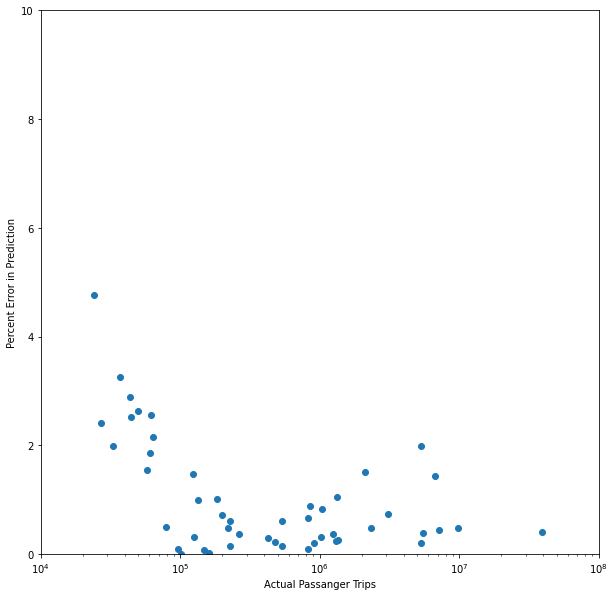

In [92]:
#Some discarded attempts to look at performance

plt.rcParams["figure.figsize"] = (10,10)

plt.scatter(test_trips, abs(predictions2-test_trips)/test_trips)
plt.xlabel("Actual Passanger Trips")
plt.ylabel("Percent Error in Prediction")
#plt.yscale(value = "log")
plt.ylim([0,10])
plt.xscale(value = "log")
plt.xlim([10000,100000000])

In [93]:
pd.DataFrame({'Abs Error':abs(predictions2-test_trips)}).describe()

,Abs Error
count,5.100000e+01
mean,1.220028e+06
std,2.940491e+06
min,5.591440e+02
25%,9.859088e+04
50%,1.449070e+05
75%,6.465671e+05
max,1.562398e+07


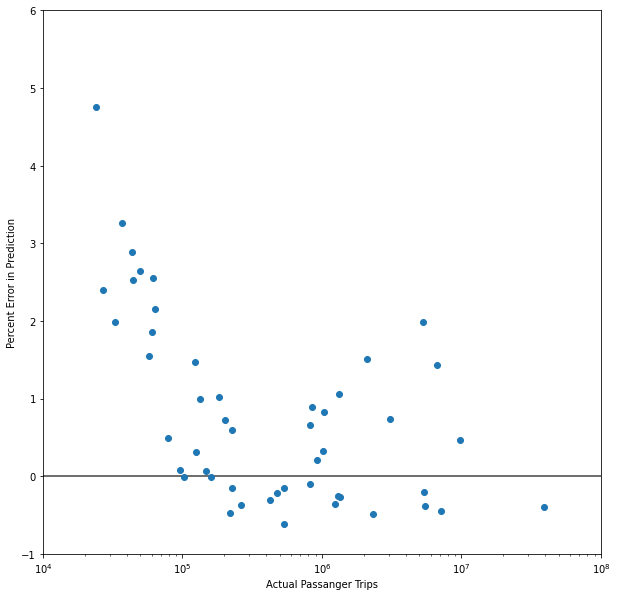

In [94]:
plt.rcParams["figure.figsize"] = (10,10)

plt.scatter(test_trips, (predictions2-test_trips)/test_trips)
plt.xlabel("Actual Passanger Trips")
plt.ylabel("Percent Error in Prediction")
#plt.yscale(value = "log")
plt.ylim([-1,6])
plt.xscale(value = "log")
plt.xlim([10000,100000000])
plt.plot([10000,1000000000], [0,0], 'k-', alpha=0.75, zorder=0)

In [95]:
combined_df_corr = combined_df[combined_df['Avg 2018']>0]
#combined_df_corr['State'] = combined_df_corr['State'].astype("category")

#corrDF = combined_df_corr.corr()
#corrDF_avg2018 = corrDF.iloc[:,-1:]

#ridershipCorr = corrDF_avg2018.sort_values('Avg 2018')
#fig, ax = plt.subplots(figsize = (5, 5))
#sns.heatmap(ridershipCorr, cmap ='RdYlGn', linewidths = 0.30, annot = True).set(title='Avg 2018 Ridership Correlations')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

[Text(0.5, 1.0, 'Avg 2018 Ridership Correlations')]

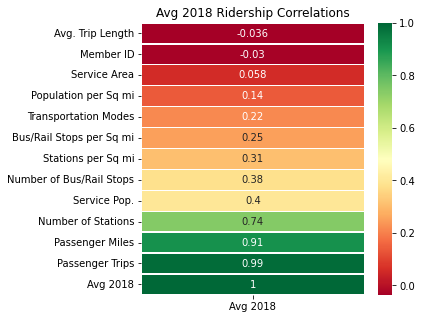

In [96]:
#correlations normalized to area

combined_df_corr_with_calc = combined_df_corr

combined_df_corr_with_calc['Stations per Sq mi'] = combined_df_corr_with_calc['Number of Stations']/combined_df_corr_with_calc['Service Area']
combined_df_corr_with_calc['Bus/Rail Stops per Sq mi'] = combined_df_corr_with_calc['Number of Bus/Rail Stops']/combined_df_corr_with_calc['Service Area']
combined_df_corr_with_calc['Population per Sq mi'] = combined_df_corr_with_calc['Service Pop.']/combined_df_corr_with_calc['Service Area']

corr_with_calc_DF = combined_df_corr_with_calc.corr()
corr_with_calc_DF_avg2018 = corr_with_calc_DF.iloc[:,-4:-3]

ridershipCorr_with_calc = corr_with_calc_DF_avg2018.sort_values('Avg 2018')
fig, ax = plt.subplots(figsize = (5, 5))
sns.heatmap(ridershipCorr_with_calc, cmap ='RdYlGn', linewidths = 0.30, annot = True).set(title='Avg 2018 Ridership Correlations')

In [97]:
#Random Forest for ridership
#using log inputs and output
RF3_df = RF_df.copy()


#RF3_df[RF3_df['Avg 2018'] > 100000000]
#RF3_df[RF3_df['Avg 2018'] < 100]
#idx_to_drop = []
#idx_to_drop.append(RF3_df[RF3_df['Avg 2018'] > 100000000].index[0])
#idx_to_drop.append(RF3_df[RF3_df['Avg 2018'] < 100].index[0])
#idx_to_drop = [20, 207]
#idx_to_drop = [257,292]
#idx_to_drop = [171,137]
#RF3_df.drop(idx_to_drop, inplace = True)

In [98]:
RF3_df['log Stations']= np.where(RF3_df['Number of Stations']==0, -1, np.log(RF3_df['Number of Stations']))
RF3_df['log Bus/Rail Stops']= np.where(RF3_df['Number of Bus/Rail Stops']==0, -1, np.log(RF3_df['Number of Bus/Rail Stops']))
RF3_df['log Avg 2018']= np.log(RF3_df['Avg 2018'])

RF3_df

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Number of Stations,Number of Bus/Rail Stops,Service Area,Service Pop.,Avg 2018,Transportation Modes,log Stations,log Bus/Rail Stops,log Avg 2018
0,4,1504,581.0,375586.0,2.042737e+05,2,1.386294,7.315884,12.227216
1,16,2155,97.0,773244.0,9.628693e+05,2,2.772589,7.675546,13.777673
2,1,5500,357.0,806893.0,1.014226e+06,2,0.000000,8.612503,13.829637
4,0,340,170.0,214437.0,9.635075e+04,2,-1.000000,5.828946,11.475750
5,27,25,1520.0,1879815.0,4.333333e+01,1,3.295837,3.218876,3.768922
...,...,...,...,...,...,...,...,...,...
304,1,750,59.0,271314.0,2.061250e+05,2,0.000000,6.620073,12.236238
305,0,616,225.0,328500.0,1.836606e+05,2,-1.000000,6.423247,12.120845
306,1,546,39.0,112933.0,7.202417e+04,2,0.000000,6.302619,11.184757
307,2,3145,504.0,694144.0,8.163733e+05,3,0.693147,8.053569,13.612627


In [99]:
trips = np.array(RF3_df['log Avg 2018'])
RF3_df = RF3_df.drop(['Avg 2018', 'Service Area', 'log Avg 2018', 'Number of Stations', 'Number of Bus/Rail Stops'] , axis = 1)

feature_list = list(RF3_df.columns)

features = np.array(RF3_df)
RF3_df
train_features, test_features, train_trips, test_trips = train_test_split(features, trips, test_size = 0.20, random_state = 11)

print('Training Features Shape:', train_features.shape)
print('Training Trips Shape:', train_trips.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Trips Shape:', test_trips.shape)

Training Features Shape: (203, 4)
Training Trips Shape: (203,)
Testing Features Shape: (51, 4)
Testing Trips Shape: (51,)


In [100]:
rf3 = RandomForestRegressor(n_estimators = 1000, random_state = 11)
rf3.fit(train_features, train_trips)

RandomForestRegressor(n_estimators=1000, random_state=11)

Root Mean Squared Error: 1.38 trips


Text(0, 0.5, 'Predicted Passanger Trips')

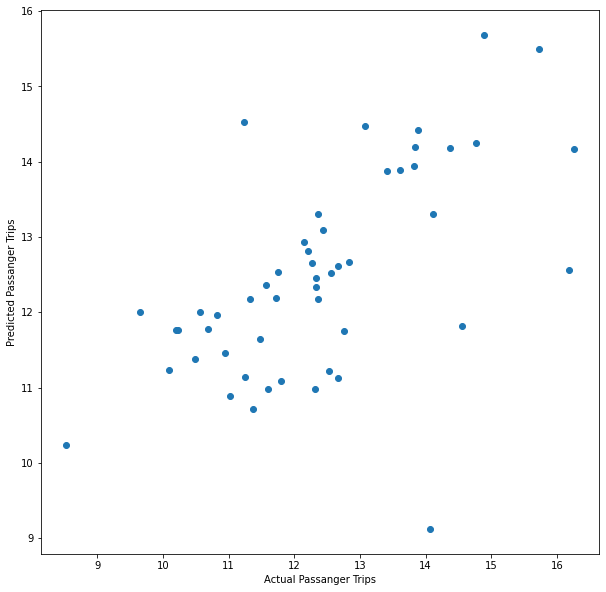

In [101]:
predictions3 = rf3.predict(test_features)
errors = abs(predictions3 - test_trips)

print('Root Mean Squared Error:', round(math.sqrt(np.mean(errors ** 2)), 2), 'trips')

plt.scatter(test_trips, predictions3)
plt.xlabel("Actual Passanger Trips")
plt.ylabel("Predicted Passanger Trips")
#plt.yscale(value = "log")
#plt.ylim([10000,100000000])
#plt.xscale(value = "log")
#plt.xlim([10000,100000000])

In [102]:
# Get numerical feature importances
importances = list(rf3.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: log Bus/Rail Stops   Importance: 0.5
Variable: Service Pop.         Importance: 0.23
Variable: log Stations         Importance: 0.22
Variable: Transportation Modes Importance: 0.05


In [ ]:
##Run at your own risk - It is slow and inaccurate

### Trying a different model 
#Duplicating  to use a copy to split test and train
keras_df = RF_df.copy()

trips = np.array(keras_df['Avg 2018'])
keras_df = keras_df.drop('Avg 2018', axis = 1)

feature_list = list(keras_df.columns)

features = np.array(keras_df)



In [ ]:
train_features, test_features, train_trips, test_trips = train_test_split(features, trips, test_size = 0.2, random_state = 11)

print('Training Features Shape:', train_features.shape)
print('Training Trips Shape:', train_trips.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Trips Shape:', test_trips.shape)

Training Features Shape: (203, 5)
Training Trips Shape: (203,)
Testing Features Shape: (51, 5)
Testing Trips Shape: (51,)


In [ ]:
#train_features = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)

print("x_train shape:", train_features.shape)
print(train_features.shape[0], "train samples")
print(test_features.shape[0], "test samples")

x_train shape: (203, 5)
203 train samples
51 test samples


In [ ]:
ten = keras.layers.Dense(units = 1, input_shape = [5])

model = keras.Sequential([ten])

In [ ]:
model.compile(loss = 'mean_squared_error',
              optimizer = keras.optimizers.Adam(0.01) #0.1 here is the learning rate
             )

In [ ]:
train = model.fit(train_features, train_trips, epochs = 100000, verbose = False )

print("training has been finished")

training has been finished


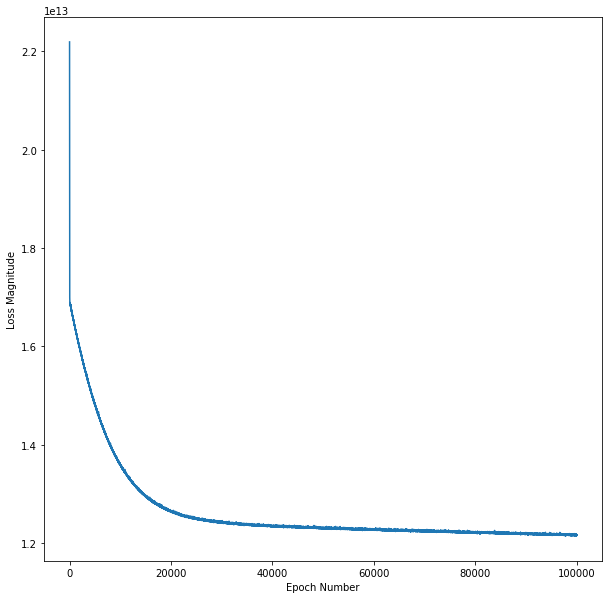

In [ ]:
plt.xlabel('Epoch Number')

plt.ylabel('Loss Magnitude')

plt.plot(train.history['loss'])
#plt.yscale('log')

In [ ]:
 ten_predictions = model.predict(test_features)

Root Mean Squared Error: 36760190.39 trips


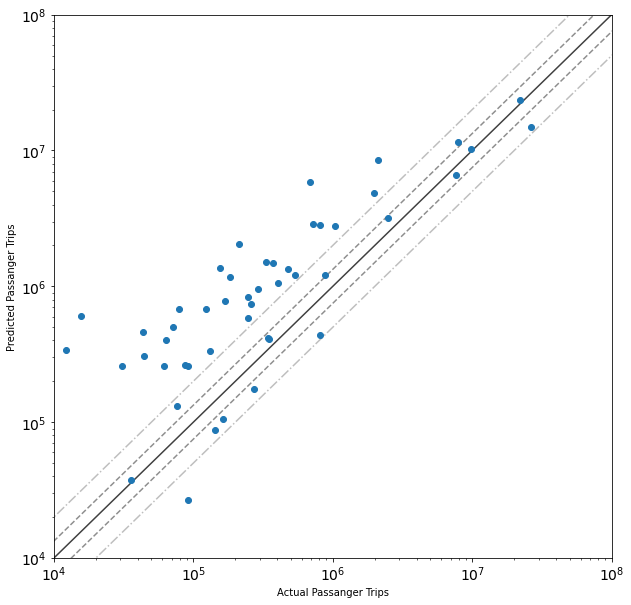

In [ ]:

errors = abs(ten_predictions.reshape([51,]) - test_trips)

print('Root Mean Squared Error:', round(math.sqrt(np.mean(errors ** 2)), 2), 'trips')

plt.scatter(test_trips, ten_predictions.reshape([51,]))
plt.xlabel("Actual Passanger Trips")
plt.ylabel("Predicted Passanger Trips")
plt.yscale(value = "log")
plt.ylim([10000,100000000])
plt.yticks(fontsize = 14)
plt.xscale(value = "log")
plt.xlim([10000,100000000])
plt.xticks(fontsize = 14)
plt.plot([10000,1000000000], [10000,1000000000], 'k-', alpha=0.75, zorder=0)
plt.plot([10000,1000000000], [7500,750000000], '--', color = '#696969', alpha=0.75, zorder=0)
plt.plot([10000,1000000000], [5000,500000000], '-.', color = '#A9A9A9', alpha=0.75, zorder=0)
plt.plot([7500,750000000], [10000,1000000000], '--', color = '#696969', alpha=0.75, zorder=0)
plt.plot([5000,500000000], [10000,1000000000], '-.', color = '#A9A9A9', alpha=0.75, zorder=0)

In [ ]:
results = pd.DataFrame({'Actual': test_trips, 'Predicted':ten_predictions.reshape([51,])})
results

,Actual,Predicted
0,2.457837e+05,8.362843e+05
1,7.902244e+06,1.154042e+07
2,2.600796e+05,7.480109e+05
3,4.022960e+05,1.066431e+06
4,1.558383e+04,6.099670e+05
5,2.635293e+07,1.500607e+07
6,5.050667e+03,-2.481744e+06
7,6.906036e+05,5.870204e+06
8,8.852690e+05,1.211248e+06
9,5.324150e+05,1.217412e+06


In [103]:
## Looking at data with miles
miles_pred_df = combined_df_with_miles[combined_df_with_miles['Miles']>0]
miles_pred_df

,Organization Name,Organization Short Name,City,State,Country,Member ID,Number of Stations,Number of Bus/Rail Stops,Agency,Service Area,Service Pop.,Passenger Miles,Passenger Trips,Avg. Trip Length,Transportation Modes,Avg 2018,Miles,Max. Speed
5,New Mexico Department of Transportation,New Mexico HTD,Santa Fe,NM,UNITED STATES,882,27,25,New Mexico Department of Transportation,1520.0,1879815.0,6.463541e+06,1.008330e+05,64.101445,1,4.333333e+01,101.2,79.0
6,Miami-Dade Transit Agency,Miami-Dade TA,Miami,FL,UNITED STATES,62,64,8949,County of Miami-Dade,306.0,2496435.0,3.136358e+08,5.639718e+07,5.561197,7,6.784738e+06,56.4,58.0
7,Transportation District Commission of Hampton ...,Hampton Roads Transit,Hampton,VA,UNITED STATES,251,32,2644,Transportation District Commission of Hampton ...,738.0,1163052.0,5.142921e+07,1.027337e+07,5.006069,5,1.126287e+06,14.3,55.0
9,Utah Transit Authority,Utah Transit Auth,Salt Lake City,UT,UNITED STATES,247,99,6202,Utah Transit Authority,696.0,2131121.0,1.778171e+08,2.355929e+07,7.547639,7,3.681361e+06,223.6,79.0
12,Northern Indiana Commuter Transportation District,Northern IN CTD,Michigan City,IN,UNITED STATES,313,20,0,Northern Indiana Commuter Transportation District,1970.0,958644.0,3.283662e+07,9.950490e+05,33.000000,1,2.833498e+05,136.9,79.0
14,Maryland Transit Administration,Maryland TA,Baltimore,MD,UNITED STATES,111,89,6055,Maryland Transit Administration,2560.0,7811145.0,5.221066e+08,7.776117e+07,6.714233,6,7.902244e+06,531.9,125.0
18,Dallas Area Rapid Transit Authority,Dallas Area RTA,Dallas,TX,UNITED STATES,851,78,11383,Dallas Area Rapid Transit,698.0,2437200.0,3.140119e+08,4.994383e+07,6.287302,6,5.334454e+06,187.6,65.0
28,San Diego Metropolitan Transit System,San Diego MTS,San Diego,CA,UNITED STATES,315,62,4609,San Diego Metropolitan Transit System,720.0,2462707.0,3.573127e+08,7.122408e+07,5.016740,4,7.112284e+06,102.6,50.0
30,Portland Streetcar,Portland Streetcar,Portland,OR,UNITED STATES,14591,0,41,Greater Portland Transit District,71.0,109535.0,5.627915e+06,1.065893e+06,5.280000,2,1.622532e+05,5.9,15.0
40,Port Authority of Allegheny County,Port Auth of Allegheny Co,Pittsburgh,PA,UNITED STATES,216,52,6955,Port Authority of Allegheny County,775.0,1415244.0,2.190735e+08,5.178715e+07,4.230267,4,5.351809e+06,51.4,50.0


In [104]:
#Random Forest for ridership
#adding miles and max speed
RF4_df = miles_pred_df[['Number of Stations', 'Number of Bus/Rail Stops',	'Service Area',	'Service Pop.', 'Avg 2018', 'Transportation Modes', 'Miles', 'Max. Speed']]
RF4_df = RF4_df[RF4_df['Avg 2018']> 0]
RF4_df = RF4_df[RF4_df['Max. Speed']>0]
RF4_df.describe()

,Number of Stations,Number of Bus/Rail Stops,Service Area,Service Pop.,Avg 2018,Transportation Modes,Miles,Max. Speed
count,56.000000,56.000000,56.000000,5.600000e+01,5.600000e+01,56.000000,56.000000,56.000000
mean,66.553571,4499.946429,842.267857,2.536555e+06,1.068336e+07,3.678571,188.378571,58.642857
std,88.432598,5218.309414,1000.710266,2.768063e+06,3.786918e+07,1.945691,251.596841,25.541715
min,0.000000,0.000000,3.000000,9.247700e+04,4.333333e+01,1.000000,0.400000,4.000000
25%,13.000000,6.250000,263.250000,7.514665e+05,3.539059e+05,2.000000,18.075000,48.750000
50%,32.000000,3219.500000,492.500000,1.568129e+06,1.817813e+06,3.000000,94.750000,58.500000
75%,89.500000,7198.750000,941.000000,3.206184e+06,7.259994e+06,5.000000,230.050000,79.000000
max,485.000000,19500.000000,5325.000000,1.117034e+07,2.807795e+08,8.000000,1041.900000,125.000000


In [105]:
trips = np.array(RF4_df['Avg 2018'])
RF4_df = RF4_df.drop('Avg 2018', axis = 1)

feature_list = list(RF4_df.columns)

features = np.array(RF4_df)


In [106]:
train_features, test_features, train_trips, test_trips = train_test_split(features, trips, test_size = 0.1, random_state = 11)

print('Training Features Shape:', train_features.shape)
print('Training Trips Shape:', train_trips.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Trips Shape:', test_trips.shape)

Training Features Shape: (50, 7)
Training Trips Shape: (50,)
Testing Features Shape: (6, 7)
Testing Trips Shape: (6,)


In [107]:
rf4 = RandomForestRegressor(n_estimators = 1000, random_state = 11)
rf4.fit(train_features, train_trips)

RandomForestRegressor(n_estimators=1000, random_state=11)

Root Mean Squared Error: 735114.85 trips


Text(0.5, 1.0, 'Random Forest Regression\nWith Route Miles and Max. Speed')

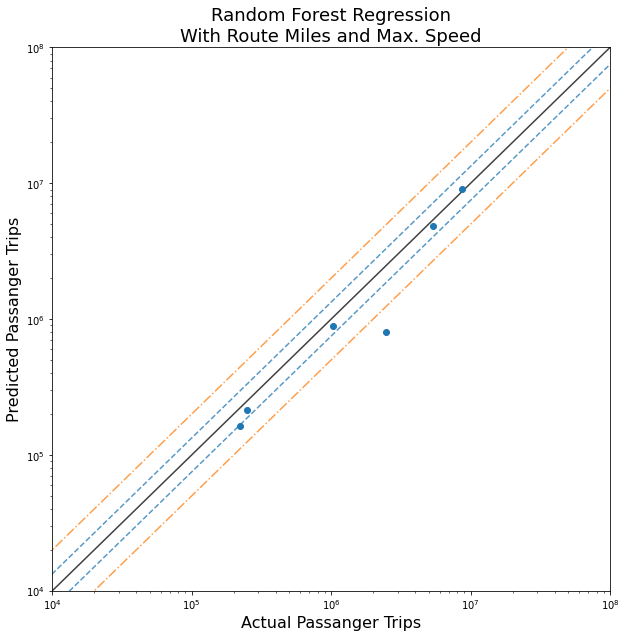

In [110]:
predictions = rf4.predict(test_features)
errors = abs(predictions - test_trips)

print('Root Mean Squared Error:', round(math.sqrt(np.mean(errors ** 2)), 2), 'trips')

plt.scatter(test_trips, predictions)
plt.xlabel("Actual Passanger Trips", size = 16)
plt.ylabel("Predicted Passanger Trips", size = 16)
plt.yscale(value = "log")
plt.ylim([10000,100000000])
plt.xscale(value = "log")
plt.xlim([10000,100000000])
plt.plot([10000,1000000000], [10000,1000000000], 'k-', alpha=0.75, zorder=0)
plt.plot([10000,1000000000], [7500,750000000], '--', alpha=0.75, zorder=0)
plt.plot([10000,1000000000], [5000,500000000], '-.', alpha=0.75, zorder=0)
plt.plot([7500,750000000], [10000,1000000000], '--', color = '#1f77b4', alpha=0.75, zorder=0)
plt.plot([5000,500000000], [10000,1000000000], '-.', color = '#ff7f0e', alpha=0.75, zorder=0)
plt.title("Random Forest Regression\nWith Route Miles and Max. Speed", size = 18)

In [111]:
# Get numerical feature importances
importances = list(rf4.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Number of Stations   Importance: 0.8
Variable: Number of Bus/Rail Stops Importance: 0.11
Variable: Miles                Importance: 0.04
Variable: Service Pop.         Importance: 0.02
Variable: Service Area         Importance: 0.01
Variable: Transportation Modes Importance: 0.01
Variable: Max. Speed           Importance: 0.01


In [112]:
# Adding in 2017 ridership
#Truncate upt to only include 2017
upt_2017_cols = ['Agency', 'JAN17', 'FEB17', 'MAR17', 'APR17', 'MAY17', 'JUN17',
                 'JUL17', 'AUG17', 'SEP17', 'OCT17', 'NOV17', 'DEC17']
upt_2017_df = upt_df[upt_2017_cols]
upt_2017_nulls = upt_2017_df[upt_2017_df['Agency'].isnull()].index.tolist()

upt_2017_df.drop(upt_2017_nulls, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [113]:
upt_2017_df

,Agency,JAN17,FEB17,MAR17,APR17,MAY17,JUN17,JUL17,AUG17,SEP17,OCT17,NOV17,DEC17
0,King County Department of Metro Transit,69528.0,63363.0,76764.0,71981.0,75959.0,72475.0,69215.0,74755.0,67205.0,75435.0,70504.0,66971.0
1,King County Department of Metro Transit,7555.0,7293.0,8647.0,8110.0,9198.0,8843.0,8549.0,8569.0,8333.0,9894.0,9874.0,8996.0
2,King County Department of Metro Transit,29690.0,29192.0,36883.0,42832.0,63252.0,69767.0,89020.0,65502.0,62049.0,52902.0,30879.0,27986.0
3,King County Department of Metro Transit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,King County Department of Metro Transit,8322531.0,7741480.0,8897619.0,8522858.0,8976802.0,8667512.0,8348447.0,8750954.0,8240729.0,8990050.0,8256206.0,7414381.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,City of Glendale,120399.0,128981.0,164124.0,143467.0,166575.0,139862.0,117710.0,144435.0,140894.0,135253.0,128137.0,107463.0
2246,City of Pasadena,NaN,NaN,NaN,NaN,NaN,NaN,6277.0,6893.0,6024.0,6855.0,6555.0,6169.0
2247,City of Pasadena,NaN,NaN,NaN,NaN,NaN,NaN,121105.0,142903.0,131669.0,139042.0,126474.0,120562.0
2248,Pomona Valley Transportation Authority,6546.0,6912.0,8029.0,7696.0,8609.0,7986.0,7747.0,8504.0,7258.0,7967.0,6950.0,6849.0


In [114]:
#summing 2017 ridership by agency
upt_2017_df = upt_2017_df.groupby(['Agency']).sum()
upt_2017_df = upt_2017_df.reset_index()
upt_2017_df

,Agency,JAN17,FEB17,MAR17,APR17,MAY17,JUN17,JUL17,AUG17,SEP17,OCT17,NOV17,DEC17
0,"2Plus Partners in Transportation, Inc",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ATC / Vancom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Academy Lines, Inc.",288695.0,258763.0,308241.0,269214.0,309030.0,306763.0,266063.0,301894.0,272763.0,299146.0,270080.0,230718.0
3,Access Services,194138.0,179350.0,210093.0,190132.0,205819.0,196077.0,190257.0,197773.0,187436.0,205768.0,183959.0,169766.0
4,Access Services,148235.0,146864.0,172836.0,165762.0,172997.0,169257.0,168117.0,198408.0,171667.0,181592.0,176415.0,171984.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,"vRide, Inc. - Anchorage",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
805,"vRide, Inc. - Atlanta",61409.0,59415.0,69473.0,58949.0,25961.0,21821.0,16587.0,0.0,0.0,0.0,0.0,0.0
806,"vRide, Inc. - El Paso",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807,"vRide, Inc. - Tucson",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
#getting average 2017 monthly ridership by agency
upt_2017_df['Avg 2017'] = upt_2017_df.mean(axis = 1)
upt_2017_df = upt_2017_df[['Agency', 'Avg 2017']]                                           
upt_2017_df


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


,Agency,Avg 2017
0,"2Plus Partners in Transportation, Inc",0.000000
1,ATC / Vancom,0.000000
2,"Academy Lines, Inc.",281780.833333
3,Access Services,192547.333333
4,Access Services,170344.500000
...,...,...
804,"vRide, Inc. - Anchorage",0.000000
805,"vRide, Inc. - Atlanta",26134.583333
806,"vRide, Inc. - El Paso",0.000000
807,"vRide, Inc. - Tucson",0.000000


In [116]:
#merging DF to include 2017 ridership
combined_df_with2017 = combined_df.merge(upt_2017_df, how = "inner", on="Agency")
combined_df_with2017

,Organization Name,Organization Short Name,City,State,Country,Member ID,Number of Stations,Number of Bus/Rail Stops,Agency,Service Area,Service Pop.,Passenger Miles,Passenger Trips,Avg. Trip Length,Transportation Modes,Avg 2018,Avg 2017
0,Stark Area Regional Transit Authority,Stark Area RTA,Canton,OH,UNITED STATES,190,4,1504,Stark Area Regional Transit Authority,581.0,375586.0,9222375.0,1334801.0,6.909176,2,2.042737e+05,2.019639e+05
1,San Mateo County Transit District,San Mateo County TD,San Carlos,CA,UNITED STATES,30,16,2155,San Mateo County Transit District,97.0,773244.0,39269344.0,9227255.0,4.255799,2,9.628693e+05,1.014605e+06
2,Transit Authority of River City,TA of River City,Louisville,KY,UNITED STATES,103,1,5500,Transit Authority of River City,357.0,806893.0,39128540.0,8711427.0,4.491634,2,1.014226e+06,1.057013e+06
3,Simi Valley Transit,Simi Valley Transit,Simi Valley,CA,UNITED STATES,36,0,238,City of Simi Valley,42.0,126878.0,0.0,0.0,0.000000,2,0.000000e+00,0.000000e+00
4,County of Lackawanna Transit System,NaN,Scranton,PA,UNITED STATES,213,0,340,County of Lackawanna Transit System,170.0,214437.0,4710006.0,923727.0,5.098916,2,9.635075e+04,9.471333e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,City of Modesto Modesto Area Express - MAX,MAX,Modesto,CA,UNITED STATES,2723,1,750,City of Modesto,59.0,271314.0,8735832.0,2057603.0,4.245635,2,2.061250e+05,2.321821e+05
287,Eastern Contra Costa Transit Authority,Eastern Contra Costa TA,Antioch,CA,UNITED STATES,819,0,616,The Eastern Contra Costa Transit Authority,225.0,328500.0,7503076.0,1535179.0,4.887427,2,1.836606e+05,2.000855e+05
288,Pueblo Transit,Pueblo Transit,Pueblo,CO,UNITED STATES,47,1,546,City of Pueblo,39.0,112933.0,1965716.0,496659.0,3.957879,2,7.202417e+04,7.310225e+04
289,Metropolitan Transit Authority,Metropolitan TA,Nashville,TN,UNITED STATES,230,2,3145,Metropolitan Transit Authority,504.0,694144.0,36759655.0,7719131.0,4.762149,3,8.163733e+05,7.992855e+05


In [117]:
#Random Forest for ridership
#including 2017 ridership
RF5_df = combined_df_with2017[['Number of Stations', 'Number of Bus/Rail Stops',	'Service Area',	'Service Pop.', 'Avg 2018', 'Transportation Modes', 'Avg 2017']]
RF5_df = RF5_df[RF5_df['Avg 2018']> 0]

#RF5_df[RF5_df['Avg 2018']<100]
#RF5_df[RF5_df['Avg 2018']>100000000]

#idx_to_drop = [18, 191]
#idx_to_drop = [240, 274]
#idx_to_drop = [124, 156]

#idx_to_drop = []
#idx_to_drop.append(RF5_df[RF5_df['Avg 2018'] > 100000000].index[0])
#idx_to_drop.append(RF5_df[RF5_df['Avg 2018'] < 100].index[0])

#RF5_df.drop(idx_to_drop, inplace = True)

RF5_df.describe()

,Number of Stations,Number of Bus/Rail Stops,Service Area,Service Pop.,Avg 2018,Transportation Modes,Avg 2017
count,254.000000,254.000000,254.000000,2.540000e+02,2.540000e+02,254.000000,2.540000e+02
mean,18.303150,2042.850394,527.511811,1.024310e+06,2.834891e+06,2.803150,2.879982e+06
std,49.139298,3125.473035,927.708779,1.746993e+06,1.818403e+07,1.291746,1.857028e+07
min,0.000000,0.000000,3.000000,1.976600e+04,4.333333e+01,1.000000,0.000000e+00
25%,1.000000,151.500000,71.250000,1.683232e+05,1.096864e+05,2.000000,1.076320e+05
50%,3.000000,831.500000,242.500000,4.113830e+05,2.727973e+05,3.000000,2.774173e+05
75%,11.000000,2513.500000,525.250000,9.652905e+05,9.776045e+05,3.000000,9.800140e+05
max,485.000000,19500.000000,9189.000000,1.117034e+07,2.807795e+08,8.000000,2.868078e+08


In [118]:
trips = np.array(RF5_df['Avg 2018'])
RF5_df = RF5_df.drop('Avg 2018', axis = 1)

feature_list = list(RF5_df.columns)

features = np.array(RF5_df)

In [119]:
train_features, test_features, train_trips, test_trips = train_test_split(features, trips, test_size = 0.2, random_state = 11)

print('Training Features Shape:', train_features.shape)
print('Training Trips Shape:', train_trips.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Trips Shape:', test_trips.shape)

Training Features Shape: (203, 6)
Training Trips Shape: (203,)
Testing Features Shape: (51, 6)
Testing Trips Shape: (51,)


In [120]:
rf5 = RandomForestRegressor(n_estimators = 1000, random_state = 11)
rf5.fit(train_features, train_trips)

RandomForestRegressor(n_estimators=1000, random_state=11)

Root Mean Squared Error: 582081.11 trips


Text(0.5, 1.0, 'Predicted vs. Actual \nMonthly Unlinked Passanger Trips\nWith 2017  Ridership')

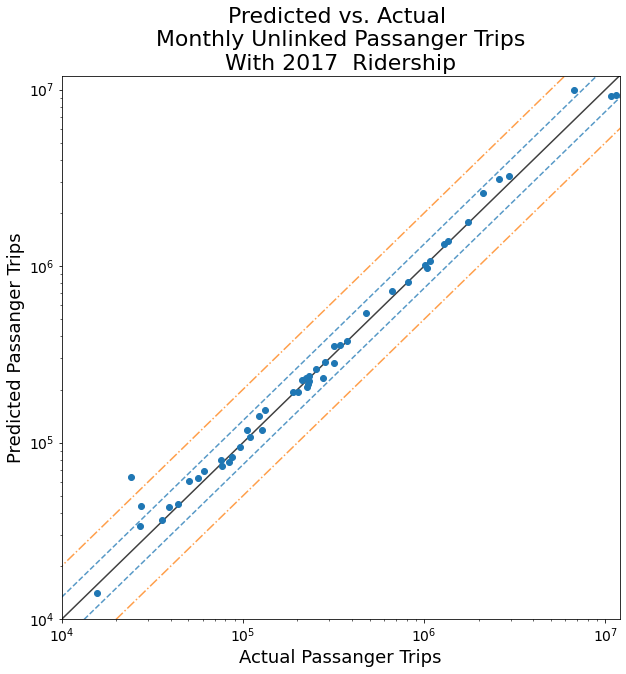

In [128]:
predictions5 = rf5.predict(test_features)
errors = abs(predictions5 - test_trips)

print('Root Mean Squared Error:', round(math.sqrt(np.mean(errors ** 2)), 2), 'trips')

plt.rcParams["figure.figsize"] = (10,10)

plt.scatter(test_trips, predictions5)
plt.xlabel("Actual Passanger Trips", size = 18)
plt.ylabel("Predicted Passanger Trips", size = 18)
plt.yscale(value = "log")
plt.ylim([10000,12000000])
plt.xscale(value = "log")
plt.xlim([10000,12000000])
#plt.plot([100,10000000000], [100,10000000000], 'k-', alpha=0.75, zorder=0)
#plt.plot([100,10000000000], [75,7500000000], '--', alpha=0.75, zorder=0)
#plt.plot([100,10000000000], [50,5000000000], '-.', alpha=0.75, zorder=0)
#plt.plot([75,7500000000], [100,10000000000], '--', color = '#1f77b4', alpha=0.75, zorder=0)
#plt.plot([50,5000000000], [100,10000000000], '-.', color = '#ff7f0e', alpha=0.75, zorder=0)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.plot([100,10000000000], [100,10000000000], 'k-', alpha=0.75, zorder=0)
#plt.plot([100,10000000000], [75,7500000000], '--', color = '#696969', alpha=0.75, zorder=0)  # gray
#plt.plot([100,10000000000], [50,5000000000], '-.', color = '#A9A9A9', alpha=0.75, zorder=0)  #gray
plt.plot([100,10000000000], [75,7500000000], '--', color = '#1f77b4', alpha=0.75, zorder=0) 
plt.plot([100,10000000000], [50,5000000000], '-.', color = '#ff7f0e', alpha=0.75, zorder=0)
plt.plot([75,7500000000], [100,10000000000], '--', color = '#1f77b4', alpha=0.75, zorder=0)
plt.plot([50,5000000000], [100,10000000000], '-.', color = '#ff7f0e', alpha=0.75, zorder=0)
plt.title("Predicted vs. Actual \nMonthly Unlinked Passanger Trips\nWith 2017  Ridership", size = 22)

In [122]:
#Saving results
RF_ResultsDF['M5 Actual'] = test_trips
RF_ResultsDF['M5 Pred'] = predictions5

In [129]:
# Get numerical feature importances
importances = list(rf5.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Avg 2017             Importance: 0.71
Variable: Number of Stations   Importance: 0.27
Variable: Number of Bus/Rail Stops Importance: 0.02
Variable: Service Area         Importance: 0.0
Variable: Service Pop.         Importance: 0.0
Variable: Transportation Modes Importance: 0.0


In [130]:
#Random Forest for ridership
#normalized to service population
RF_perpop_df = RF_df.copy()

#RF_perpop_df[RF_perpop_df['Avg 2018'] > 100000000]
#RF_perpop_df[RF_perpop_df['Avg 2018'] < 100]

#idx_to_drop = [20, 207]
#idx_to_drop = [257,292]
#RF_perpop_df.drop(idx_to_drop, inplace = True)

RF_perpop_df["Rides per Person"] = RF_perpop_df['Avg 2018']/RF_perpop_df['Service Pop.']

In [131]:
trips = np.array(RF_perpop_df['Rides per Person'])
pop = RF_perpop_df['Service Pop.']
RF_perpop_df = RF_perpop_df.drop(['Avg 2018', 'Rides per Person', 'Service Pop.'], axis = 1)

feature_list = list(RF_perpop_df.columns)

features = np.array(RF_perpop_df)

train_features, test_features, train_trips, test_trips = train_test_split(features, trips, test_size = 0.2, random_state = 11)

print('Training Features Shape:', train_features.shape)
print('Training Trips Shape:', train_trips.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Trips Shape:', test_trips.shape)

Training Features Shape: (203, 4)
Training Trips Shape: (203,)
Testing Features Shape: (51, 4)
Testing Trips Shape: (51,)


In [132]:
rfpop = RandomForestRegressor(n_estimators = 1000, random_state = 11)
rfpop.fit(train_features, train_trips)

RandomForestRegressor(n_estimators=1000, random_state=11)

Root Mean Squared Error: 1.7802380666382263


(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14.]),
 <a list of 9 Text major ticklabel objects>)

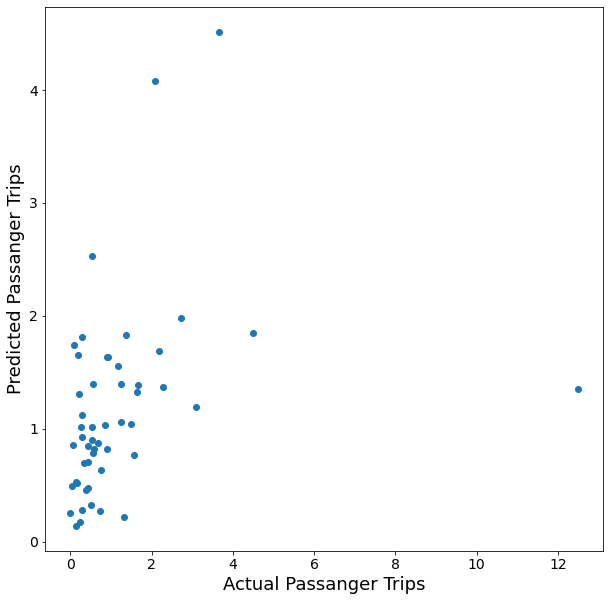

In [133]:
predictionsPop = rfpop.predict(test_features)
errors = abs(predictionsPop - test_trips)

#print('Root Mean Squared Error:', round(math.sqrt(np.mean(errors ** 2)), 2), 'trips')
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_trips, predictionsPop)))

plt.rcParams["figure.figsize"] = (10,10)

plt.scatter(test_trips, predictionsPop)
plt.xlabel("Actual Passanger Trips", size = 18)
plt.ylabel("Predicted Passanger Trips", size = 18)
#plt.yscale(value = "log")
#plt.ylim([10000,100000000])
plt.yticks(fontsize = 14)
#plt.xscale(value = "log")
#plt.xlim([10000,100000000])
plt.xticks(fontsize = 14)
#plt.plot([10000,1000000000], [10000,1000000000], 'k-', alpha=0.75, zorder=0)
#plt.plot([10000,1000000000], [7500,750000000], '--', color = '#696969', alpha=0.75, zorder=0)
#plt.plot([10000,1000000000], [5000,500000000], '-.', color = '#A9A9A9', alpha=0.75, zorder=0)
#plt.plot([7500,750000000], [10000,1000000000], '--', color = '#696969', alpha=0.75, zorder=0)
#plt.plot([5000,500000000], [10000,1000000000], '-.', color = '#A9A9A9', alpha=0.75, zorder=0)
#plt.annotate("50% Error", xy=(10000000, 5000000), weight = 'bold',
#             xytext=(0.85, .65), textcoords='axes fraction',horizontalalignment='right',
#             verticalalignment='top', size = 16, color = '#A9A9A9', rotation = 45)
#plt.annotate("", xy=(10000000, 5000000), arrowprops=dict(facecolor='#A9A9A9', shrink=0.05),
#             xytext=(0.8, .62), textcoords='axes fraction',horizontalalignment='right',
#             verticalalignment='top', size = 16, color = '#A9A9A9')
#plt.annotate("25% Error", xy=(25000000, 18750000), weight = 'bold',
#             xytext=(0.95, .82), textcoords='axes fraction',horizontalalignment='right',
#             verticalalignment='top', size = 16, color = '#696969', rotation = 45)
#plt.annotate("", xy=(25000000, 18750000), arrowprops=dict(facecolor='#696969', shrink=0.05),
#             xytext=(0.89, .78), textcoords='axes fraction',horizontalalignment='right',
#             verticalalignment='top', size = 16, color = '#696969')
#plt.title("Predicted vs. Actual \nMonthly Unlinked Passanger Trips", size = 22)

In [134]:
RF_ResultsDF

,M1 Actual,M1 Pred,M2 Actual,M2 Pred,M5 Actual,M5 Pred
0,2.401908e+04,1.015124e+05,5.315816e+05,2.048882e+05,2.401908e+04,6.404084e+04
1,1.079778e+06,2.547431e+06,1.319449e+06,2.712611e+06,1.079778e+06,1.072003e+06
2,2.329118e+05,2.571240e+05,8.194972e+05,1.362046e+06,2.329118e+05,2.243907e+05
3,7.568933e+04,1.909549e+06,6.392767e+04,2.017731e+05,7.568933e+04,7.934240e+04
4,5.050667e+03,2.886450e+05,9.156670e+05,1.105719e+06,5.050667e+03,3.299253e+04
5,2.276491e+05,2.905702e+05,5.324150e+05,4.511723e+05,2.276491e+05,2.158919e+05
6,2.233456e+05,6.256646e+04,5.517152e+06,3.381122e+06,2.233456e+05,2.309938e+05
7,1.283868e+06,4.538975e+05,3.085048e+06,5.372598e+06,1.283868e+06,1.332153e+06
8,2.768923e+05,7.101138e+04,1.230537e+05,3.043792e+05,2.768923e+05,2.323015e+05
9,1.072186e+07,9.858824e+05,1.019190e+05,1.013599e+05,1.072186e+07,9.226316e+06


In [135]:
##Exploring 3 RF results for comparison

M1 = pd.DataFrame({'Actual': RF_ResultsDF['M1 Actual'], 'M1 Pred':RF_ResultsDF['M1 Pred']})
M2 = pd.DataFrame({'Actual': RF_ResultsDF['M2 Actual'], 'M2 Pred':RF_ResultsDF['M2 Pred']})
M5 = pd.DataFrame({'Actual': RF_ResultsDF['M5 Actual'], 'M5 Pred':RF_ResultsDF['M5 Pred']})

M1_M2 = M1.merge(M2, how = "inner", on="Actual")
M1_M2_M5 = M1_M2.merge(M5, how = 'inner', on="Actual")

In [136]:
M1_M2_M5['M1 Percent'] = abs(M1_M2_M5['M1 Pred'] -M1_M2_M5['Actual'])/M1_M2_M5['Actual']
M1_M2_M5['M2 Percent'] = abs(M1_M2_M5['M2 Pred'] -M1_M2_M5['Actual'])/M1_M2_M5['Actual']
M1_M2_M5['M5 Percent'] = abs(M1_M2_M5['M5 Pred'] -M1_M2_M5['Actual'])/M1_M2_M5['Actual']

In [137]:
M1_avg = M1_M2_M5['M1 Percent'].mean()
M2_avg = M1_M2_M5['M2 Percent'].mean()
M5_avg = M1_M2_M5['M5 Percent'].mean()
print(round(M1_avg,4))
print(round(M2_avg,4))
print(round(M5_avg,4))


5.6267
6.6371
0.6143


(0.0, 10.0)

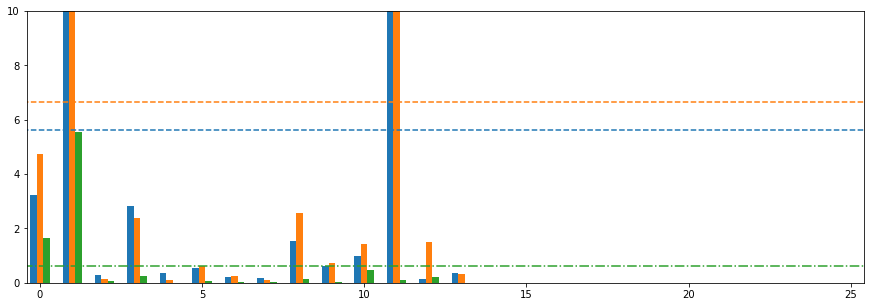

In [138]:
plt.rcParams["figure.figsize"] = (15,5)

X_axis = np.arange(len(M1_M2_M5))

plt.bar(X_axis-.2, M1_M2_M5['M1 Percent'], .2, label = 'Model 1')
plt.bar(X_axis, M1_M2_M5['M2 Percent'], .2, label = 'Model 2')
plt.bar(X_axis+.2, M1_M2_M5['M5 Percent'], .2, label = 'Model 5')

plt.plot([-1, 26], [M1_avg, M1_avg],'--', color='#1f77b4')
plt.plot([-1,26], [M2_avg, M2_avg], '--', color='#ff7f0e')
plt.plot([-1,26], [M5_avg, M5_avg], '-.', color='#2ca02c')

plt.xlim(-.4,25.4)
plt.ylim(0,10)

In [ ]:
plt.plot([7500,750000000], [10000,1000000000], '--', color = '#1f77b4', alpha=0.75, zorder=0)
plt.plot([5000,500000000], [10000,1000000000], '-.', color = '#ff7f0e', alpha=0.75, zorder=0)

Text(0, 0.5, '                                                             Percent Error (decimal)')

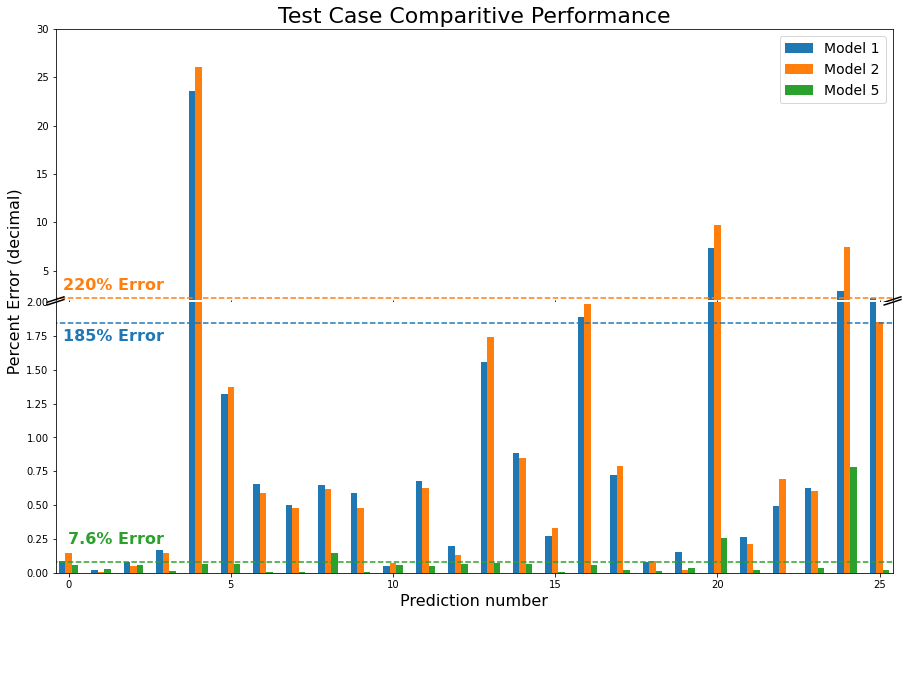

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)

X_axis = np.arange(len(M1_M2_M5))

f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

ax.bar(X_axis-.2, M1_M2_M5['M1 Percent'], .2, label = 'Model 1')
ax.bar(X_axis, M1_M2_M5['M2 Percent'], .2, label = 'Model 2')
ax.bar(X_axis+.2, M1_M2_M5['M5 Percent'], .2, label = 'Model 5')

ax.plot([-1, 26], [M1_avg, M1_avg],'--', color='#1f77b4')
ax.plot([-1,26], [M2_avg, M2_avg], '--', color='#ff7f0e')
ax.plot([-1,26], [M5_avg, M5_avg], '--', color='#2ca02c')

ax2.bar(X_axis-.2, M1_M2_M5['M1 Percent'], .2, label = 'Model 1')
ax2.bar(X_axis, M1_M2_M5['M2 Percent'], .2, label = 'Model 2')
ax2.bar(X_axis+.2, M1_M2_M5['M5 Percent'], .2, label = 'Model 5')

ax2.plot([-1, 26], [M1_avg, M1_avg],'--', color='#1f77b4')
ax2.plot([-1,26], [M2_avg, M2_avg], '--', color='#ff7f0e')
ax2.plot([-1,26], [M5_avg, M5_avg], '--', color='#2ca02c')


ax.set_xlim(-.4,25.4)

ax.set_ylim(2,30)
ax2.set_ylim(0,2)

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs) 

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
f.subplots_adjust(hspace=.01)

ax.legend(prop={'size': 14})

ax2.annotate('185% Error', xy=(0, 1.6), weight = 'bold',
             xytext=(.13,.90), textcoords='axes fraction',horizontalalignment='right',
             verticalalignment='top', size = 16, color = '#1f77b4')
ax.annotate('220% Error', xy=(0, 2.5), weight = 'bold',
             xytext=(.13,.08), textcoords='axes fraction',horizontalalignment='right',
             verticalalignment='top', size = 16, color = '#ff7f0e')
ax2.annotate('7.6% Error', xy=(0, .25), weight = 'bold',
             xytext=(.13,.15), textcoords='axes fraction',horizontalalignment='right',
             verticalalignment='top', size = 16, color = '#2ca02c')

ax.set_title("Test Case Comparitive Performance", size = 22)

plt.xlabel("Prediction number", size = 16)
plt.ylabel("                                                             Percent Error (decimal)", size = 16)

